# Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np 
import json
import requests
import datetime
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gpd
import seaborn as sns
import ppscore
from scipy import stats

In [2]:
# Load dataframe created in data wrangling phase
# Parse datetime column and make index
df= pd.read_csv('Data/csv/cleaned_cov_weather4.csv', parse_dates=['date'], index_col ='date')

In [3]:
df.head()

,vt_avg_temp,vt_prcp,me_avg_temp,me_prcp,ct_avg_temp,ct_prcp,ma_avg_temp,ma_prcp,CT_conf_cases,ME_conf_cases,MA_conf_cases,VT_conf_cases
date,,,,,,,,,,,,
2020-01-22,-28,0,-72.0,0.0,-76.0,0.0,-53.0,0.0,0,0,0,0
2020-01-23,-27,0,-30.0,3.0,-46.0,0.0,0.0,0.0,0,0,0,0
2020-01-24,-8,0,-14.0,0.0,6.0,0.0,19.0,0.0,0,0,0,0
2020-01-25,3,119,-30.0,3.0,23.0,218.0,33.0,25.0,0,0,0,0
2020-01-26,22,23,11.0,132.0,49.0,0.0,64.0,193.0,0,0,0,0


In [4]:
# Check for duplicated DateTimeIndices
df[df.index.duplicated()]

,vt_avg_temp,vt_prcp,me_avg_temp,me_prcp,ct_avg_temp,ct_prcp,ma_avg_temp,ma_prcp,CT_conf_cases,ME_conf_cases,MA_conf_cases,VT_conf_cases
date,,,,,,,,,,,,
2020-11-29,44,0,19.0,0.0,46.0,0.0,50.0,0.0,112581,11508,224964,4100
2020-11-29,44,0,19.0,0.0,46.0,0.0,50.0,0.0,112581,11508,224964,4100
2020-11-29,44,0,19.0,0.0,46.0,0.0,50.0,0.0,112581,11508,224964,4100
2020-11-30,61,170,53.0,503.0,57.0,478.0,80.0,122.0,117295,11757,226132,4172


In [5]:
# Remove duplicated DateTimeIndices (but keep first instances of indices)
# Check to confirm duplicated indices have been removed 
df = df[~df.index.duplicated(keep='first')]
df[df.index.duplicated()]

,vt_avg_temp,vt_prcp,me_avg_temp,me_prcp,ct_avg_temp,ct_prcp,ma_avg_temp,ma_prcp,CT_conf_cases,ME_conf_cases,MA_conf_cases,VT_conf_cases
date,,,,,,,,,,,,


In [6]:
# double check data types
df.dtypes

vt_avg_temp        int64
vt_prcp            int64
me_avg_temp      float64
me_prcp          float64
ct_avg_temp      float64
ct_prcp          float64
ma_avg_temp      float64
ma_prcp          float64
CT_conf_cases      int64
ME_conf_cases      int64
MA_conf_cases      int64
VT_conf_cases      int64
dtype: object

In [7]:
# Convert int columns to float in preparation for calculations:
int_columns= {"CT_conf_cases": 'float', "ME_conf_cases": 'float', "MA_conf_cases":"float", "VT_conf_cases":'float', "vt_avg_temp":'float', "vt_prcp":'float'}
df = df.astype(int_columns)

In [8]:
df.dtypes

vt_avg_temp      float64
vt_prcp          float64
me_avg_temp      float64
me_prcp          float64
ct_avg_temp      float64
ct_prcp          float64
ma_avg_temp      float64
ma_prcp          float64
CT_conf_cases    float64
ME_conf_cases    float64
MA_conf_cases    float64
VT_conf_cases    float64
dtype: object

In [9]:
# Any missing values?
df[pd.isnull(df).any(axis=1)]

,vt_avg_temp,vt_prcp,me_avg_temp,me_prcp,ct_avg_temp,ct_prcp,ma_avg_temp,ma_prcp,CT_conf_cases,ME_conf_cases,MA_conf_cases,VT_conf_cases
date,,,,,,,,,,,,


No missing values.

However, the units of TAVG and PRCP are clearly off. 

According to [NOAA documentation](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt), temperatures are reported in __*tenths*__ of a degree Celsius. I'll convert to degrees Fahrenheit instead (since this is US data here).

In [10]:
# (C*9/50)+32=F (since C is reported here as tenths of degrees)
df2=df
df2['vt_avg_temp'] = ((df['vt_avg_temp']*9)/50) + 32
df2['me_avg_temp'] = ((df['me_avg_temp']*9)/50) + 32
df2['ct_avg_temp'] = ((df['ct_avg_temp']*9)/50) + 32
df2['ma_avg_temp'] = ((df['ma_avg_temp']*9)/50) + 32

The [same documention](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) cited above also explains that PRCP data is reported in __*tenths*__ of a mm. [Wikipedia](https://en.wikipedia.org/wiki/Precipitation) reports that generally PRCP data is reported in millimeters, so I'll convert to millimeters instead.

In [11]:
df3=df2
df3['vt_prcp'] = df2['vt_prcp']/10
df3['me_prcp'] = df2['me_prcp']/10
df3['ct_prcp'] = df2['ct_prcp']/10
df3['ma_prcp'] = df2['ma_prcp']/10

In [12]:
df3.head()

,vt_avg_temp,vt_prcp,me_avg_temp,me_prcp,ct_avg_temp,ct_prcp,ma_avg_temp,ma_prcp,CT_conf_cases,ME_conf_cases,MA_conf_cases,VT_conf_cases
date,,,,,,,,,,,,
2020-01-22,26.96,0.0,19.04,0.0,18.32,0.0,22.46,0.0,0.0,0.0,0.0,0.0
2020-01-23,27.14,0.0,26.60,0.3,23.72,0.0,32.00,0.0,0.0,0.0,0.0,0.0
2020-01-24,30.56,0.0,29.48,0.0,33.08,0.0,35.42,0.0,0.0,0.0,0.0,0.0
2020-01-25,32.54,11.9,26.60,0.3,36.14,21.8,37.94,2.5,0.0,0.0,0.0,0.0
2020-01-26,35.96,2.3,33.98,13.2,40.82,0.0,43.52,19.3,0.0,0.0,0.0,0.0


For the sake of clarity, I'll update column names to reflect this unit change.

In [13]:
#Update column names to reflect new units:
units_dict= {'vt_avg_temp': 'VT_Avg_Temp(F)', 'vt_prcp': 'VT_PRCP(mm)', 'me_avg_temp':'ME_Avg_Temp(F)', 'me_prcp': 'ME_PRCP(mm)', 'ct_avg_temp': 'CT_Avg_Temp(F)', 'ct_prcp':'CT_PRCP(mm)', 'ma_avg_temp': 'MA_Avg_Temp(F)', 'ma_prcp':'MA_PRCP(mm)'}
df3.rename(columns=units_dict, inplace=True)
df3.head()

,VT_Avg_Temp(F),VT_PRCP(mm),ME_Avg_Temp(F),ME_PRCP(mm),CT_Avg_Temp(F),CT_PRCP(mm),MA_Avg_Temp(F),MA_PRCP(mm),CT_conf_cases,ME_conf_cases,MA_conf_cases,VT_conf_cases
date,,,,,,,,,,,,
2020-01-22,26.96,0.0,19.04,0.0,18.32,0.0,22.46,0.0,0.0,0.0,0.0,0.0
2020-01-23,27.14,0.0,26.60,0.3,23.72,0.0,32.00,0.0,0.0,0.0,0.0,0.0
2020-01-24,30.56,0.0,29.48,0.0,33.08,0.0,35.42,0.0,0.0,0.0,0.0,0.0
2020-01-25,32.54,11.9,26.60,0.3,36.14,21.8,37.94,2.5,0.0,0.0,0.0,0.0
2020-01-26,35.96,2.3,33.98,13.2,40.82,0.0,43.52,19.3,0.0,0.0,0.0,0.0


In [14]:
#Examine timespan of data:
print('Beginning date: ',min(df3.index))
print('End date: ', max(df3.index))
print('Total timespan: ', max(df3.index-min(df3.index)))

Beginning date:  2020-01-22 00:00:00
End date:  2021-09-12 00:00:00
Total timespan:  599 days 00:00:00


In [15]:
# Make copy of df 
df4=df3.copy()

The confirmed cases column represented total number of cumulative new COVID cases per date. To explore new infection *rates* over time, rather than cumulative COVID cases, we'll have to take the first differences of the cumulative counts. There shouldn't be any `NaN`s left, but just in case, we'll chain the `.fillna()` method to the end of our first differences calls.

In [16]:
# Make column of non-cumulative counts of confirmed cases for each state:
df4["CT_Conf_Cases"] = df4['CT_conf_cases'].diff().fillna(0)
df4["VT_Conf_Cases"] = df4['VT_conf_cases'].diff().fillna(0)
df4["ME_Conf_Cases"] = df4['ME_conf_cases'].diff().fillna(0)
df4["MA_Conf_Cases"] = df4['MA_conf_cases'].diff().fillna(0)

In [17]:
# Drop cumulative confirmed case columns:
df5 = df4.drop(columns=['CT_conf_cases', 'VT_conf_cases', 'ME_conf_cases', 'MA_conf_cases'])

In [18]:
# Take a look at some summary statistics of the data:
# First, we'll define a function to highlight any negative values (as we can't have negative new COVID case values)
def highlight_neg(cell):
    if cell < 0 :
        return 'background: yellow'  
df5.describe().style.applymap(highlight_neg)

,VT_Avg_Temp(F),VT_PRCP(mm),ME_Avg_Temp(F),ME_PRCP(mm),CT_Avg_Temp(F),CT_PRCP(mm),MA_Avg_Temp(F),MA_PRCP(mm),CT_Conf_Cases,VT_Conf_Cases,ME_Conf_Cases,MA_Conf_Cases
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,51.115400,2.239833,45.224000,2.853500,54.263300,3.502333,54.381950,3.787833,631.555000,50.190000,134.188333,1295.036667
std,19.936095,5.804667,19.548057,8.950529,17.516293,10.068826,16.950279,10.299207,1110.107736,63.347234,171.873540,1568.531084
min,2.120000,0.000000,-1.840000,0.000000,11.660000,0.000000,14.000000,0.000000,-15.000000,-1.000000,-1.000000,-280.000000
25%,35.060000,0.000000,30.020000,0.000000,39.155000,0.000000,39.920000,0.000000,0.000000,3.000000,18.000000,200.750000
50%,51.980000,0.000000,46.760000,0.000000,55.580000,0.000000,55.040000,0.000000,165.500000,13.500000,42.000000,658.500000
75%,68.000000,1.300000,62.150000,1.300000,70.160000,1.300000,68.630000,2.000000,738.750000,94.000000,211.000000,1884.250000
max,84.920000,63.500000,80.060000,131.100000,85.640000,103.400000,87.980000,95.000000,8457.000000,357.000000,824.000000,9003.000000


The negative value in `ME_Avg_Temp(F)` column is fine, however it looks like some of the states have `Conf_Cases` values that are less than zero. That can't be right; this needs to be looked into. Let's first see how many negative values are in each state's confirmed case counts and how large or small the values are. These will be considerations when we decide how to best address them.

In [19]:
CT_neg = df5[df5['CT_Conf_Cases']<0]
print("CT has", len(CT_neg), "negative case value(s):")
print(CT_neg.CT_Conf_Cases)

CT has 2 negative case value(s):
date
2020-05-27   -15.0
2020-08-18   -12.0
Name: CT_Conf_Cases, dtype: float64


In [20]:
VT_neg = df5[df5['VT_Conf_Cases']<0]
print("VT has", len(VT_neg), "negative case value(s):")
print(VT_neg.VT_Conf_Cases)

VT has 2 negative case value(s):
date
2020-05-11   -1.0
2020-06-17   -1.0
Name: VT_Conf_Cases, dtype: float64


In [21]:
ME_neg = df5[df5['ME_Conf_Cases']<0]
print("ME has", len(ME_neg), "negative case value(s):")
print(ME_neg.ME_Conf_Cases)

ME has 4 negative case value(s):
date
2020-03-15   -1.0
2020-07-22   -1.0
2020-09-09   -1.0
2021-08-09   -1.0
Name: ME_Conf_Cases, dtype: float64


In [22]:
MA_neg = df5[df5['MA_Conf_Cases']<0]
print("MA has", len(MA_neg), "negative case value(s):")
print(MA_neg.MA_Conf_Cases)

MA has 1 negative case value(s):
date
2020-09-03   -280.0
Name: MA_Conf_Cases, dtype: float64


Connecticut has two negative case counts, Vermont also has two negative case counts, Maine has four negative case counts, and Massachusetts has one negative case count (for a total of 9 negative case counts). Thankfully we don't have *a lot* of these erroneous counts, but before blindly filling them all with zeroes, let's check to see what the case counts around these dates look like. If they're very low, we may be able to fill the negative values with zeroes without much impact. If these values occur during a surge, however, we may need to look a little deeper. 

In [23]:
# Print day before and after each negative case value in CT:
ct_neg_df = pd.DataFrame(pd.concat([df5['2020-05-26':'2020-05-28'].CT_Conf_Cases, 
                                    df5['2020-08-17':'2020-08-19'].CT_Conf_Cases]))
ct_neg_df.style.applymap(highlight_neg)

,CT_Conf_Cases
date,
2020-05-26 00:00:00,430.000000
2020-05-27 00:00:00,-15.000000
2020-05-28 00:00:00,271.000000
2020-08-17 00:00:00,370.000000
2020-08-18 00:00:00,-12.000000
2020-08-19 00:00:00,59.000000


In [24]:
# Print day before and after each negative case value in VT:
vt_neg_df = pd.DataFrame(pd.concat([df5['2020-05-10':'2020-05-12'].VT_Conf_Cases, 
                                    df5['2020-06-16':'2020-06-18'].VT_Conf_Cases]))
vt_neg_df.style.applymap(highlight_neg)

,VT_Conf_Cases
date,
2020-05-10 00:00:00,6.000000
2020-05-11 00:00:00,-1.000000
2020-05-12 00:00:00,1.000000
2020-06-16 00:00:00,3.000000
2020-06-17 00:00:00,-1.000000
2020-06-18 00:00:00,5.000000


In [25]:
# Print day before and after each negative case value in ME:
me_neg_df = pd.DataFrame(pd.concat([df5['2020-03-14':'2020-03-16'].ME_Conf_Cases, 
                                    df5['2020-07-21':'2020-07-23'].ME_Conf_Cases, 
                                    df5['2020-09-08':'2020-09-10'].ME_Conf_Cases, 
                                    df5['2021-08-08':'2021-08-10'].ME_Conf_Cases]))
me_neg_df.style.applymap(highlight_neg)

,ME_Conf_Cases
date,
2020-03-14 00:00:00,0.000000
2020-03-15 00:00:00,-1.000000
2020-03-16 00:00:00,15.000000
2020-07-21 00:00:00,12.000000
2020-07-22 00:00:00,-1.000000
2020-07-23 00:00:00,15.000000
2020-09-08 00:00:00,13.000000
2020-09-09 00:00:00,-1.000000
2020-09-10 00:00:00,47.000000


In [26]:
# Print day before and after each negative case value in MA:
ma_neg_df = pd.DataFrame(pd.concat([df5['2020-09-02':'2020-09-04'].MA_Conf_Cases]))
ma_neg_df.style.applymap(highlight_neg)

,MA_Conf_Cases
date,
2020-09-02 00:00:00,404.000000
2020-09-03 00:00:00,-280.000000
2020-09-04 00:00:00,212.000000


If Vermont was the only state with negative case counts, it may be alright to fill negative case counts with zeroes, but all other states would likely be adversely affected by this. For example, Massachusetts has a case count value of -280, between dates with case counts of positive 404 and 212. Maine, too, has a value of -1 right before a value of 361 cases (which is a large case count for this less-populous state). Therefore, let's replace these negative case count values with the average of the case counts of the date before and after them. To do this, we'll first convert the negative values to `NaN`s, and then we'll use the `.fillna()` method. 

In [27]:
# Replace cases negative values with np.nan
df5.MA_Conf_Cases['2020-09-03'] = np.nan
df5.CT_Conf_Cases[['2020-05-27', '2020-08-18']] = np.nan
df5.VT_Conf_Cases[['2020-05-11', '2020-06-17']] = np.nan
df5.ME_Conf_Cases[['2020-03-15','2020-07-22', '2020-09-09', '2021-08-09']]= np.nan

In [28]:
# Loop through NaNs and fill with average of previous and following cell values 
state_col_list=['CT_Conf_Cases', 'VT_Conf_Cases', 'ME_Conf_Cases', 'MA_Conf_Cases']
for col in state_col_list:
    df5[col] = df5[col].fillna((df5[col].shift() + df5[col].shift(-1))/2)

Now all of the negative case values should have been replaced with the average of the value preceding and following it. Let's double check the summary statistics of the full DataFrame just to make sure everything looks good.

In [29]:
 df5.describe().style.applymap(highlight_neg)

,VT_Avg_Temp(F),VT_PRCP(mm),ME_Avg_Temp(F),ME_PRCP(mm),CT_Avg_Temp(F),CT_PRCP(mm),MA_Avg_Temp(F),MA_PRCP(mm),CT_Conf_Cases,VT_Conf_Cases,ME_Conf_Cases,MA_Conf_Cases
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,51.115400,2.239833,45.224000,2.853500,54.263300,3.502333,54.381950,3.787833,632.541667,50.205833,134.580833,1296.016667
std,19.936095,5.804667,19.548057,8.950529,17.516293,10.068826,16.950279,10.299207,1109.671640,63.335011,171.729819,1567.728859
min,2.120000,0.000000,-1.840000,0.000000,11.660000,0.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.060000,0.000000,30.020000,0.000000,39.155000,0.000000,39.920000,0.000000,0.000000,3.000000,19.000000,202.500000
50%,51.980000,0.000000,46.760000,0.000000,55.580000,0.000000,55.040000,0.000000,169.500000,13.500000,42.000000,658.500000
75%,68.000000,1.300000,62.150000,1.300000,70.160000,1.300000,68.630000,2.000000,738.750000,94.000000,211.000000,1884.250000
max,84.920000,63.500000,80.060000,131.100000,85.640000,103.400000,87.980000,95.000000,8457.000000,357.000000,824.000000,9003.000000


Now there are no more negative COVID case counts in the DataFrame; the only negative values belong to an average temperature column (which makes sense- Maine gets pretty cold in the winter!).

A quick look at the tail of the DataFrame reveals another interesting detail, however.

In [30]:
# Define a function to highlight zero values (which may be indicative of missing values)
def highlight_zero(cell):
    if cell == 0:
        return 'background: yellow'  

In [31]:
(pd.DataFrame(df5['CT_Conf_Cases'].tail(25))).style.applymap(highlight_zero)

,CT_Conf_Cases
date,
2021-08-19 00:00:00,534.000000
2021-08-20 00:00:00,431.000000
2021-08-21 00:00:00,0.000000
2021-08-22 00:00:00,0.000000
2021-08-23 00:00:00,1554.000000
2021-08-24 00:00:00,1071.000000
2021-08-25 00:00:00,651.000000
2021-08-26 00:00:00,788.000000
2021-08-27 00:00:00,788.000000


Zeroes are sometimes, but not always, indicative of missing values. We would probably expect a certain proportion of zero values for confirmed cases in a dataset like ours, but the above highlighted values follow a pretty clear pattern (which is suspicious). For every five days of values for `Conf_Cases`, there are two days of zero values. It seems that values have not been recorded for weekends dates in Connecticut, and a quick calendar check confirms the above highlighted zero values all correspond to weekend dates. But what about Monday 2021-09-06? The calendar shows that this was [Labor Day](https://www.officeholidays.com/countries/usa/2021), a bank holiday in the US.


Let's check if the other states follow Connecticut's case reporting schedule, or some other schedule entirely. Before we do that, though, let's add a column, `weekday`, indicating the day of the week for each row of data.

In [32]:
df6 = df5.copy()
# Add a weekday column
df6["weekday"] = df6.index.dayofweek

In [33]:
df6

,VT_Avg_Temp(F),VT_PRCP(mm),ME_Avg_Temp(F),ME_PRCP(mm),CT_Avg_Temp(F),CT_PRCP(mm),MA_Avg_Temp(F),MA_PRCP(mm),CT_Conf_Cases,VT_Conf_Cases,ME_Conf_Cases,MA_Conf_Cases,weekday
date,,,,,,,,,,,,,
2020-01-22,26.96,0.0,19.04,0.0,18.32,0.0,22.46,0.0,0.0,0.0,0.0,0.0,2
2020-01-23,27.14,0.0,26.60,0.3,23.72,0.0,32.00,0.0,0.0,0.0,0.0,0.0,3
2020-01-24,30.56,0.0,29.48,0.0,33.08,0.0,35.42,0.0,0.0,0.0,0.0,0.0,4
2020-01-25,32.54,11.9,26.60,0.3,36.14,21.8,37.94,2.5,0.0,0.0,0.0,0.0,5
2020-01-26,35.96,2.3,33.98,13.2,40.82,0.0,43.52,19.3,0.0,0.0,0.0,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-08,72.86,24.1,63.50,0.0,70.16,0.0,71.96,0.0,935.0,111.0,732.0,1475.0,2
2021-09-09,67.46,0.0,62.42,35.3,71.42,3.8,70.88,8.1,626.0,152.0,620.0,2407.0,3
2021-09-10,59.90,0.5,58.46,13.0,66.92,0.0,68.54,7.6,625.0,147.0,506.0,1873.0,4


In [34]:
# Compare all states' missing value patterns
(pd.DataFrame(df6[['CT_Conf_Cases', 'MA_Conf_Cases', 'ME_Conf_Cases', 
                            'VT_Conf_Cases', 'weekday']].tail(25)).style.applymap(highlight_zero))

,CT_Conf_Cases,MA_Conf_Cases,ME_Conf_Cases,VT_Conf_Cases,weekday
date,,,,,
2021-08-19 00:00:00,534.000000,1576.000000,182.000000,169.000000,3
2021-08-20 00:00:00,431.000000,1533.000000,185.000000,115.000000,4
2021-08-21 00:00:00,0.000000,0.000000,205.000000,146.000000,5
2021-08-22 00:00:00,0.000000,0.000000,0.000000,126.000000,6
2021-08-23 00:00:00,1554.000000,3418.000000,0.000000,82.000000,0
2021-08-24 00:00:00,1071.000000,1600.000000,362.000000,105.000000,1
2021-08-25 00:00:00,651.000000,1495.000000,291.000000,118.000000,2
2021-08-26 00:00:00,788.000000,1891.000000,390.000000,149.000000,3
2021-08-27 00:00:00,788.000000,1656.000000,263.000000,144.000000,4


From the above data, it looks like Massachusetts and Connecticut may have similar Monday-Friday reporting schedules. It also seems that Maine may report cases Tuesday-Saturday and Vermont may report cases seven days a week (at least for these last 25 rows). Three out of four of the states also reported zero values for 2021-09-06 (a Monday) which we've already determined was a US bank holiday. Notably, Vermont did report cases on this date however.

It's clear that each state's reporting schedule varies, and also that there may be some unsual exceptions to these schedules (like bank holidays) for some states. Clearly we'll need to investigate each state's individual reporting schedule more closely. We may get a better idea of the overall distribution and pattern of these zero values by representing them visually. 

Below I plot each state's daily new confirmed case counts. In the plots for Massachusetts, Connecticut, and Vermont, there is an orange vertical line for every zero value that falls on a Saturday, a red vertical line for every zero value that falls on a Sunday, and a green vertical line for every zero value that falls on any day of the week other than Saturday or Sunday.

Because Maine seems to follow a different schedule, I've placed a red vertical line for every zero count that falls on *Sunday*, an orange vertical line for every zero value that falls on a *Monday*, and a green vertical line for every zero value that falls on any day of the week other than Sunday or Monday.

By plotting the orange and red lines, we'll be able to check our hypothesis regarding each state's reporting schedule. By plotting the green lines, we'll be able to double check for any unusual cases of zero values that do not fit within our hypothesized reporting schedules.

In [35]:
df7 = df6
sunday_ind_me=(df7[(df7.weekday == 6)&(df7.ME_Conf_Cases==0)& (df7.index >'2020-01-29')]).index # Sunday zero values
monday_ind_me=(df7[(df7.weekday == 0)&(df7.ME_Conf_Cases==0)&(df7.index>'2020-01-29')]).index # Monday zero values
# Zero values that are neither Sunday nor Monday
other_ind_me=(df7[(df7.weekday != 0)& (df7.weekday != 6)&(df7.ME_Conf_Cases==0)& (df7.index >'2020-01-29')]).index  

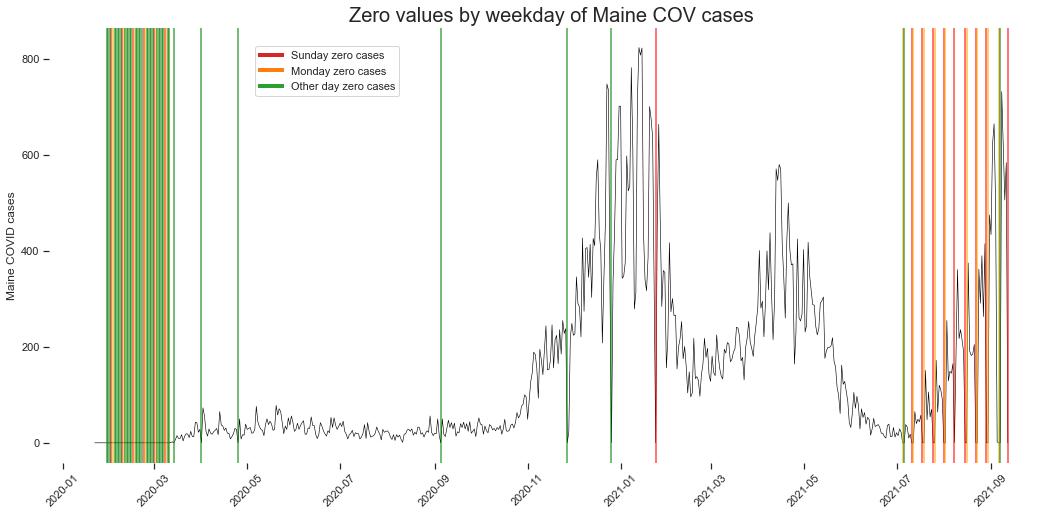

In [36]:
legend_elements = [Line2D([0], [0], color='tab:red', lw=4, label='Sunday zero cases'),
                   Line2D([0], [0], color='tab:orange', lw=4, label='Monday zero cases'),
                   Line2D([0], [0], color='tab:green', lw=4, label='Other day zero cases')]

sns.set(rc={'figure.figsize':(18,8)})
with sns.axes_style("ticks"):
    fig, ax = plt.subplots()
    plt.plot(df7.index, df7['ME_Conf_Cases'], color = 'black', linewidth=0.6)
    ax.set_ylabel('Maine COVID cases')
    plt.xticks(rotation=45)
    for i in sunday_ind_me:    
        ax.axvline(x=i, color='red', alpha=0.7)
    for i in monday_ind_me:    
        ax.axvline(x=i, color='orange', alpha=0.7)
    for i in other_ind_me:    
        ax.axvline(x=i, color='green', alpha=0.7)
    plt.title('Zero values by weekday of Maine COV cases', fontsize=20)
    sns.despine(left=True, bottom=True)
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.2,0.97))
    plt.show()

It seems that (with a few individual exceptions), Maine actually reported new case counts every day of the week until around July of 2021. This means that **we'll only need to address Sunday-Monday zero case counts for Maine from July of 2021 onwards.** We can also look into the few exceptions (green lines) that occur prior to July, 2021, and check for bank holidays. We can also see that Maine did not report its first COVID case until March of 2020.

In [37]:
sunday_ind_ma=(df7[(df7.weekday == 6)&(df7.MA_Conf_Cases==0)& (df7.index >'2020-01-29')]).index # Sunday zero values
saturday_ind_ma=(df7[(df7.weekday == 5)&(df7.MA_Conf_Cases==0)&(df7.index>'2020-01-29')]).index # Saturday zero values
# Zero values that are neither Sunday nor Monday
other_ind_ma=(df7[(df7.weekday != 5)& (df7.weekday != 6)&(df7.MA_Conf_Cases==0)& (df7.index >'2020-01-29')]).index 

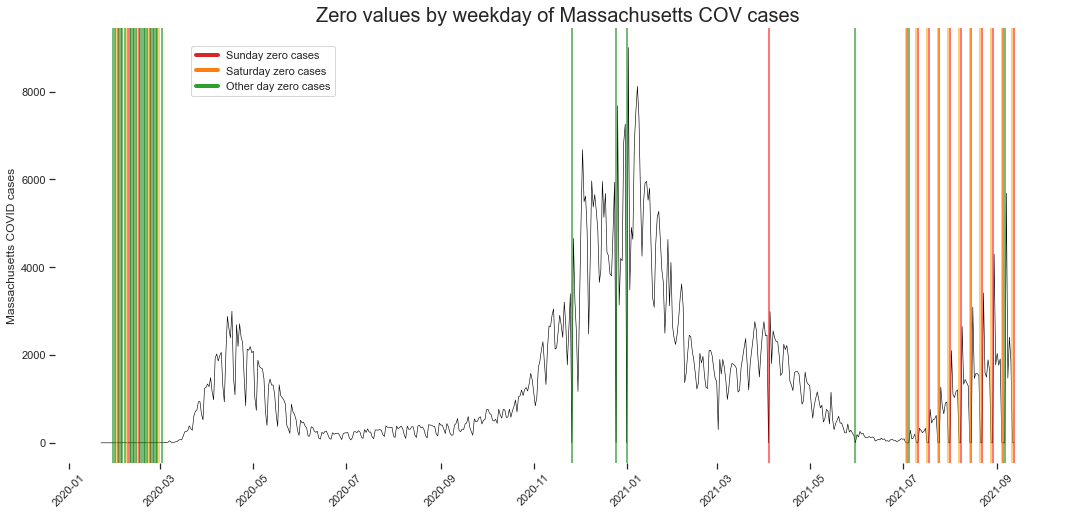

In [38]:
legend_elements = [Line2D([0], [0], color='tab:red', lw=4, label='Sunday zero cases'),
                   Line2D([0], [0], color='tab:orange', lw=4, label='Saturday zero cases'),
                   Line2D([0], [0], color='tab:green', lw=4, label='Other day zero cases')]

with sns.axes_style("ticks"):
    fig, ax = plt.subplots()
    plt.plot(df7.index, df7['MA_Conf_Cases'], color = 'black', linewidth=0.6)
    ax.set_ylabel('Massachusetts COVID cases')
    plt.xticks(rotation=45)
    for i in sunday_ind_ma:    
        ax.axvline(x=i, color='red', alpha=0.7)
    for i in saturday_ind_ma:    
        ax.axvline(x=i, color='orange', alpha=0.7)
    for i in other_ind_ma:    
        ax.axvline(x=i, color='green', alpha=0.7)
    plt.title('Zero values by weekday of Massachusetts COV cases', fontsize=20)
    sns.despine(left=True, bottom=True)
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.13,0.97))
    plt.show()

It looks like Massachusetts was also reporting case counts daily (seven days a week) until around July of 2021 (when it switched to a Monday-Friday reporting schedule). We can also examine the few exceptions (green lines) for Massachusetts, but it looks like **we'll only need to examine Saturday-Sunday zero case values for Massachusetts from July, 2021 onwards** also. We can see that Massachusetts hasn't reported any significant case values until around March of 2020 either. We may want to further slice our data to begin in March, 2020 to avoid skewing our data with these zero values, but let's first check the Connecticut and Vermont case counts to make sure we aren't dropping any useful data.

In [39]:
sunday_ind_ct=(df7[(df7.weekday == 6)&(df7.CT_Conf_Cases==0)& (df7.index >'2020-01-29')]).index # Sunday zero values
saturday_ind_ct=(df7[(df7.weekday == 5)&(df7.CT_Conf_Cases==0)&(df7.index>'2020-01-29')]).index # Saturday zero values
# Zero values that are neither Sunday nor Monday
other_ind_ct=(df7[(df7.weekday != 5)& (df7.weekday != 6)&(df7.CT_Conf_Cases==0)& (df7.index >'2020-01-29')]).index 

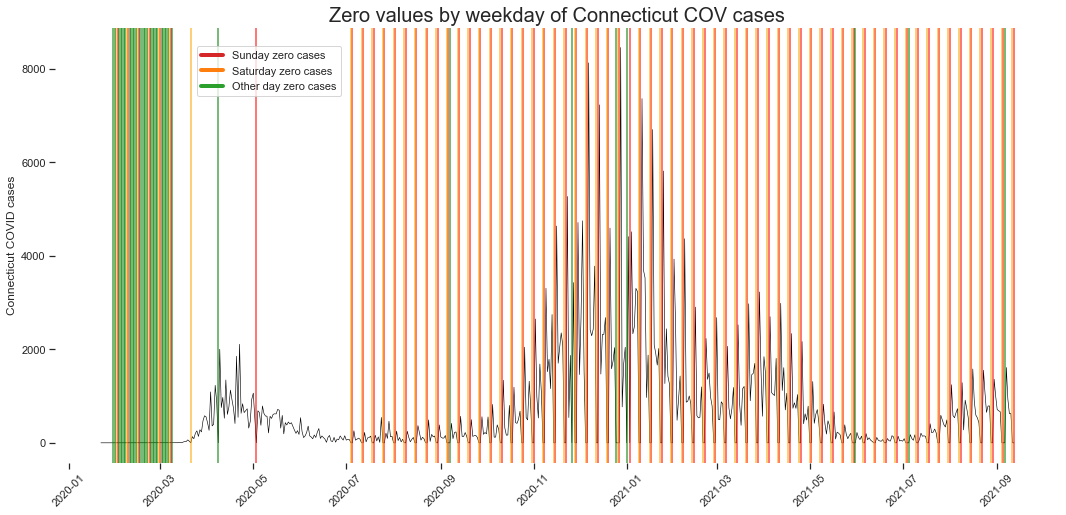

In [40]:
legend_elements = [Line2D([0], [0], color='tab:red', lw=4, label='Sunday zero cases'),
                   Line2D([0], [0], color='tab:orange', lw=4, label='Saturday zero cases'),
                   Line2D([0], [0], color='tab:green', lw=4, label='Other day zero cases')]

with sns.axes_style("ticks"):
    fig, ax = plt.subplots()
    plt.plot(df7.index, df7['CT_Conf_Cases'],  color = 'black', linewidth=0.6)
    ax.set_ylabel('Connecticut COVID cases')
    plt.xticks(rotation=45)
    for i in sunday_ind_ct:    
        ax.axvline(x=i, color='red', alpha=0.7)
    for i in saturday_ind_ct:    
        ax.axvline(x=i, color='orange', alpha=0.7)
    for i in other_ind_ct:    
        ax.axvline(x=i, color='green', alpha=0.7)
    plt.title('Zero values by weekday of Connecticut COV cases', fontsize=20)
    sns.despine(left=True, bottom=True)
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.29, 0.97))
    plt.show()

Connecticut clearly has a very different reporting schedule than Massachusetts and Maine. It looks like Connecticut only reported case counts seven days a week until around July of *2020*. **We'll need to address Saturday-Sunday zero value counts for Connecticut from July, *2020* onwards.** Connecticut also seems to have reported its first COVID case sometime in March of 2020.

In [41]:
sunday_ind_vt=(df7[(df7.weekday == 6)&(df7.VT_Conf_Cases==0)& (df7.index >'2020-01-29')]).index # Sunday zero values
saturday_ind_vt=(df7[(df7.weekday == 5)&(df7.VT_Conf_Cases==0)&(df7.index>'2020-01-29')]).index # Saturday zero values
# Zero values that are neither Sunday nor Monday
other_ind_vt=(df7[(df7.weekday != 5)& (df7.weekday != 6)&(df7.VT_Conf_Cases==0)& (df7.index >'2020-01-29')]).index 

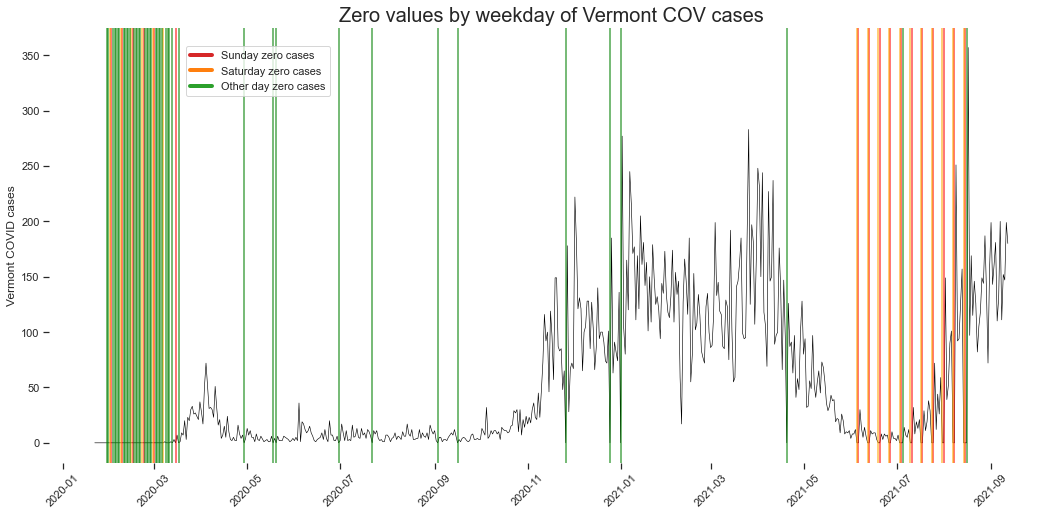

In [42]:
legend_elements = [Line2D([0], [0], color='tab:red', lw=4, label='Sunday zero cases'),
                   Line2D([0], [0], color='tab:orange', lw=4, label='Saturday zero cases'),
                   Line2D([0], [0], color='tab:green', lw=4, label='Other day zero cases')]

with sns.axes_style("ticks"):
    fig, ax = plt.subplots()
    plt.plot(df7.index, df7['VT_Conf_Cases'],  color = 'black', linewidth=0.6)
    ax.set_ylabel('Vermont COVID cases')
    plt.xticks(rotation=45)
    for i in sunday_ind_vt:    
        ax.axvline(x=i, color='red', alpha=0.7)
    for i in saturday_ind_vt:    
        ax.axvline(x=i, color='orange', alpha=0.7)
    for i in other_ind_vt:    
        ax.axvline(x=i, color='green', alpha=0.7)
    plt.title('Zero values by weekday of Vermont COV cases', fontsize=20)
    sns.despine(left=True, bottom=True)
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.285, 0.97))
    plt.show()

Vermont seems only to have followed a Monday-Friday reporting schedule for about 2-3 months, from around June of 2021 until August 2021, before reverting back to daily reporting. **We'll need to address Saturday-Sunday zero case values for Vermont from June 2021- August 2021.** Vermont also didn't report its first COVID case until sometime in March of 2020.

It seems pretty clear that we can cut all data prior to March 2020 as we only have 1 non-zero value count (from Massachusetts) prior to March, and so the repetetive zero values from this period can only serve to skew our data. 

In [43]:
# Cut data from before March of 2020
df8=df7.loc['2020-03-01':]

Let's check out how one of the plots looks after the slicing:

In [44]:
sunday_ind_vt=(df8[(df8.weekday == 6)&(df8.VT_Conf_Cases==0)& (df8.index >'2020-01-29')]).index # Sunday zero values
saturday_ind_vt=(df8[(df8.weekday == 5)&(df8.VT_Conf_Cases==0)&(df8.index>'2020-01-29')]).index # Saturday zero values
# Zero values that are neither Sunday nor Monday
other_ind_vt=(df8[(df8.weekday != 5)& (df8.weekday != 6)&(df8.VT_Conf_Cases==0)& (df8.index >'2020-01-29')]).index 

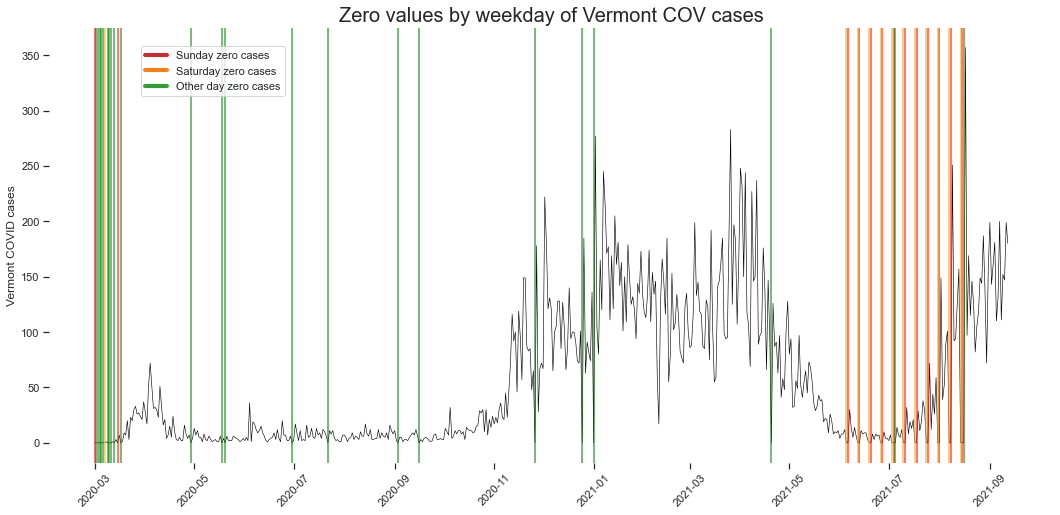

In [45]:
legend_elements = [Line2D([0], [0], color='tab:red', lw=4, label='Sunday zero cases'),
                   Line2D([0], [0], color='tab:orange', lw=4, label='Saturday zero cases'),
                   Line2D([0], [0], color='tab:green', lw=4, label='Other day zero cases')]

with sns.axes_style("ticks"):
    fig, ax = plt.subplots()
    plt.plot(df8.index, df8['VT_Conf_Cases'], color = 'black', linewidth=0.6)
    ax.set_ylabel('Vermont COVID cases')
    plt.xticks(rotation=45)
    for i in sunday_ind_vt:    
        ax.axvline(x=i, color='red', alpha=0.7)
    for i in saturday_ind_vt:    
        ax.axvline(x=i, color='orange', alpha=0.7)
    for i in other_ind_vt:    
        ax.axvline(x=i, color='green', alpha=0.7)
    plt.title('Zero values by weekday of Vermont COV cases', fontsize=20)
    sns.despine(left=True, bottom=True)
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.24, 0.97))
    plt.show()

This looks a lot better! 

Now we'll need to address each state's unique reporting schedule. 
By examining each state governments' webpages (see here: [Maine](https://www.maine.gov/dhhs/mecdc/infectious-disease/epi/airborne/coronavirus/data.shtml), [Massachusetts](https://www.mass.gov/info-details/covid-19-response-reporting), [Vermont](https://www.healthvermont.gov/covid-19), [Connecticut](https://portal.ct.gov/coronavirus/covid-19-data-tracker)), we can confirm the apparent trends in the plots above. From [this Associated Press article](https://apnews.com/article/health-coronavirus-pandemic-vermont-c781aa063d30e8f665500deaf8902ab9) we can also confirm that Vermont resumed daily case reporting on 2021-08-23 (due to a surge in cases).

More simply, each state reported cases daily, besides the following periods (and a few select bank holidays):

* **Maine** reported cases **Tuesday-Saturday** from **2021-07-01 onwards**.
* **Massachusetts** reported cases **Monday-Friday** from **2021-07-01 onwards**.
* **Connecticut** reported cases **Monday-Friday** from **2020-07-01 onwards**.
* **Vermont** reported cases **Monday-Friday** from **2021-06-01 to 2021-08-23**.

The above hyperlinked resources also describe that each state reports a cumulative total of new cases on the day following a two-day break in reporting. For Massachusetts, Connecticut, and Vermont, this would be Monday. For Maine this would be Tuesday. The resources also indicate that if the day following a two-day break in reporting (either Monday or Tuesday) is a bank holiday, then a cumulative case count for the *three* prior days will be reported on the day following the bank holiday (for Massachusetts, Connecticut, and Vermont, this would be Tuesday, and for Maine, this would be Wednesday).

Now that we've more clearly defined each state's reporting schedules, let's address the zero values. Because we know that each state reports a *cumulative total* the day following a break in reporting, we can divide this cumulative count by three and replace each of the three days' values with a third of the cumulative value for those days. Before doing so, we'll have to check to make sure none of these days fall on a bank holiday, however.

Let's quickly plot the distribution of cases per weekday before we make any changes, so we can compare with the distributions after we've updated the dataframe.

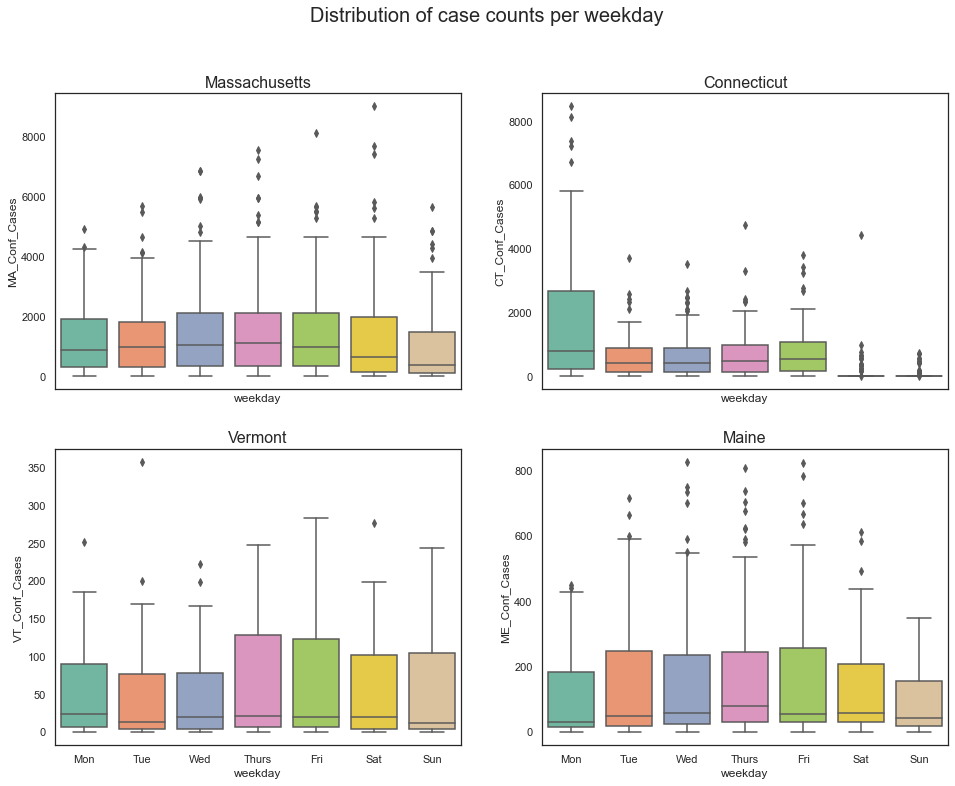

In [46]:
# Plot boxplot of distribution of cases per weekday
#plt.rcParams["figure.figsize"] = [7.50, 3.50]
weekdays =['Mon', 'Tue', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
weekday_nums = [0, 1, 2, 3, 4, 5, 6]
with sns.axes_style("white"):
    fig, axes = plt.subplots(2,2, sharex=True, figsize=(16,12))
    fig.suptitle('Distribution of case counts per weekday', fontsize=20)
    # Set suptitle and subtitles
    axes[0,0].set_title('Massachusetts', fontsize=16)
    axes[0,1].set_title('Connecticut', fontsize =16)
    axes[1,0].set_title('Vermont', fontsize= 16)
    axes[1,1].set_title('Maine', fontsize= 16)
    #Maine
    sns.boxplot(ax=axes[0, 0], data=df8, x='weekday', y='MA_Conf_Cases', palette = 'Set2')
    plt.xticks(weekday_nums, weekdays)
    #Connecticut
    sns.boxplot(ax=axes[0, 1], data=df8, x='weekday', y='CT_Conf_Cases', palette = 'Set2')
    plt.xticks(weekday_nums, weekdays)
    # Vermont
    sns.boxplot(ax=axes[1, 0], data=df8, x='weekday', y='VT_Conf_Cases', palette = 'Set2')
    plt.xticks(weekday_nums, weekdays)
    #Massachusetts
    sns.boxplot(ax=axes[1, 1], data=df8, x='weekday', y='ME_Conf_Cases', palette = 'Set2')
    plt.xticks(weekday_nums, weekdays)
    plt.show()

As we may have expected, Connecticut's case counts are the most *inconsistent* by weekday. Specifically, the mean, median, and mode of case count values for Connecticut for Saturdays and Sundays appear to be close to zero. This makes sense, as Connecticut was the only state that didn't report case counts on weekends *for almost the entirety of the pandemic.* Massachusetts, Vermont, and Maine each reported case counts *daily* for the vast majority of the pandemic, with only shorter, temporary periods of partial-week reporting schedules. We can also see that Maine clearly has it's lowest number of case counts on Sundays and Mondays, which happen to be precisely the days Maine didn't report cases towards the later stages of the pandemic. We'll replot each state's case counts per weekday after we've addressed the missing values caused by each state's reporting schedules to see how they affect the distrubtion of case counts by weekday per state. 

Now let's address the missing values caused by each state's unique reporting schedule.

## Maine

For Maine, we'll first check each confirmed case count occurring on or after 2021-07-01, on a Tuesday, that does not have a zero case count (so must not be a bank holiday on which cases were not reported), and create a column `ME_third` with a third of that value. We'll replace the original cumulative Tuesday value with one third of itself. Then we'll add 3 more columns representing lag-1, lag-2, and lag-3 of `ME_third`. We'll replace Monday zero values with lag-1 of `ME_third`, Sunday zero values with lag-2 of `ME_third`, and so on. Once this is complete we *should* only be left with missing values for non-reporting days that were part of a long weekend (bank holiday Tuesday, in the case of Maine). We'll then need to calculate using the returning Wednesday's value. 

In [47]:
df9=df8.copy()

In [48]:
df9['ME_third'] = round(df9['ME_Conf_Cases']/3)

In [49]:
me_lags = {'me_lag_1': -1, 'me_lag_2': -2, 'me_lag_3': -3}
for key, value in me_lags.items():
    df9[key] = df9['ME_third'].shift(value, axis=0)

In [50]:
for index, row in df9.iterrows():
    if (index>= pd.Timestamp('2021-07-01')) & (row['weekday']==1) & (row['ME_Conf_Cases'] != 0):
        df9.at[index, 'ME_Conf_Cases'] = df9.at[index, 'ME_third']

In [51]:
for index, row in df9.iterrows():
    if (index>= pd.Timestamp('2021-07-01')) & (row['weekday']==0) & (row['ME_Conf_Cases'] == 0):
        df9.at[index, 'ME_Conf_Cases'] = df9.at[index, 'me_lag_1']

In [52]:
for index, row in df9.iterrows():
    if (index>= pd.Timestamp('2021-07-01')) & (row['weekday']==6) & (row['ME_Conf_Cases'] == 0):
        df9.at[index, 'ME_Conf_Cases'] = df9.at[index, 'me_lag_2']

Now let's address any long weekends where Tuesday was a bank holiday by taking a third of that week's Wednesday case count and replacing Monday, Tuesday, and Wednesday's count with that value instead.

In [53]:
for index, row in df9.iterrows():
    if (index>= pd.Timestamp('2021-07-01')) & (row['weekday']==2) & (row['ME_Conf_Cases'] != 0):
        df9.at[index, 'ME_Conf_Cases'] = df9.at[index, 'ME_third']

In [54]:
for index, row in df9.iterrows():
    if (index>= pd.Timestamp('2021-07-01')) & (row['weekday']==1) & (row['ME_Conf_Cases'] == 0):
        df9.at[index, 'ME_Conf_Cases'] = df9.at[index, 'me_lag_1']

In [55]:
for index, row in df9.iterrows():
    if (index>= pd.Timestamp('2021-07-01')) & (row['weekday']==0) & (row['ME_Conf_Cases'] == 0):
        df9.at[index, 'ME_Conf_Cases'] = df9.at[index, 'me_lag_2']

Now let's check out a plot of Maine's updated case counts:

In [56]:
sunday_ind_me=(df9[(df9.weekday == 6)&(df9.ME_Conf_Cases==0)]).index # Sunday zero values
monday_ind_me=(df9[(df9.weekday == 0)&(df9.ME_Conf_Cases==0)]).index # Monday zero values
# Zero values that are neither Sunday nor Monday
other_ind_me=(df9[(df9.weekday != 0)& (df9.weekday != 6)&(df9.ME_Conf_Cases==0)]).index

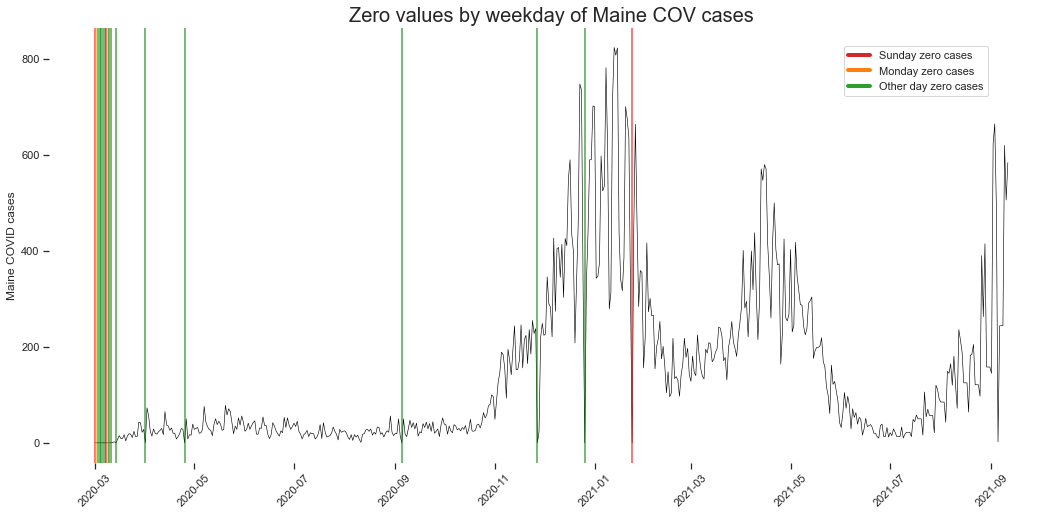

In [57]:
legend_elements = [Line2D([0], [0], color='tab:red', lw=4, label='Sunday zero cases'),
                   Line2D([0], [0], color='tab:orange', lw=4, label='Monday zero cases'),
                   Line2D([0], [0], color='tab:green', lw=4, label='Other day zero cases')]

sns.set(rc={'figure.figsize':(18,8)})
with sns.axes_style("ticks"):
    fig, ax = plt.subplots()
    plt.plot(df9.index, df9['ME_Conf_Cases'], color = 'black', linewidth=0.6)
    ax.set_ylabel('Maine COVID cases')
    plt.xticks(rotation=45)
    for i in sunday_ind_me:    
        ax.axvline(x=i, color='red', alpha=0.7)
    for i in monday_ind_me:    
        ax.axvline(x=i, color='orange', alpha=0.7)
    for i in other_ind_me:    
        ax.axvline(x=i, color='green', alpha=0.7)
    plt.title('Zero values by weekday of Maine COV cases', fontsize=20)
    sns.despine(left=True, bottom=True)
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.94, 0.97))
    plt.show()

## Connecticut

Let's do the same thing with Connecticut, only we'll replace values according to Connecticut's Monday-Friday reporting schedule from 2020-07-01 onwards. 

In [58]:
# Get rid of Maine-specific columns
df9 = df9.drop(['ME_third', 'me_lag_1', 'me_lag_2', 'me_lag_3'], axis=1)

In [59]:
# Create Connecticut-specific columns
# CT_third
df9['CT_third'] = round(df9['CT_Conf_Cases']/3)

In [60]:
# ct_lags
ct_lags = {'ct_lag_1': -1, 'ct_lag_2': -2, 'ct_lag_3': -3}
for key, value in ct_lags.items():
    df9[key] = df9['CT_third'].shift(value, axis=0)

In [61]:
for index, row in df9.iterrows():
    if (index>= pd.Timestamp('2020-07-01')) & (row['weekday']==0) & (row['CT_Conf_Cases'] != 0):
        df9.at[index, 'CT_Conf_Cases'] = df9.at[index, 'CT_third']

In [62]:
for index, row in df9.iterrows():
    if (index>= pd.Timestamp('2020-07-01')) & (row['weekday']==6) & (row['CT_Conf_Cases'] == 0):
        df9.at[index, 'CT_Conf_Cases'] = df9.at[index, 'ct_lag_1']

In [63]:
for index, row in df9.iterrows():
    if (index>= pd.Timestamp('2020-07-01')) & (row['weekday']==5) & (row['CT_Conf_Cases'] == 0):
        df9.at[index, 'CT_Conf_Cases'] = df9.at[index, 'ct_lag_2']

Now let's address any long weekends where Monday was a bank holiday by taking a third of that week's Tuesday case count and replacing Saturday, Sunday, and Monday count with that value instead

In [64]:
for index, row in df9.iterrows():
    if (index>= pd.Timestamp('2020-07-01')) & (row['weekday']==1) & (row['CT_Conf_Cases'] != 0):
        df9.at[index, 'CT_Conf_Cases'] = df9.at[index, 'CT_third']

In [65]:
for index, row in df9.iterrows():
    if (index>= pd.Timestamp('2020-07-01')) & (row['weekday']==0) & (row['CT_Conf_Cases'] == 0):
        df9.at[index, 'CT_Conf_Cases'] = df9.at[index, 'ct_lag_1']

In [66]:
for index, row in df9.iterrows():
    if (index>= pd.Timestamp('2020-07-01')) & (row['weekday']==6) & (row['CT_Conf_Cases'] == 0):
        df9.at[index, 'CT_Conf_Cases'] = df9.at[index, 'ct_lag_2']

In [67]:
for index, row in df9.iterrows():
    if (index>= pd.Timestamp('2020-07-01')) & (row['weekday']==5) & (row['CT_Conf_Cases'] == 0):
        df9.at[index, 'CT_Conf_Cases'] = df9.at[index, 'ct_lag_3']

In [68]:
sunday_ind_ct=(df9[(df9.weekday == 6)&(df9.CT_Conf_Cases==0)]).index # Sunday zero values
saturday_ind_ct=(df9[(df9.weekday == 5)&(df9.CT_Conf_Cases==0)]).index # Saturday zero values
# Zero values that are neither Sunday nor Monday
other_ind_ct=(df9[(df9.weekday != 5)& (df9.weekday != 6)&(df9.CT_Conf_Cases==0)]).index 

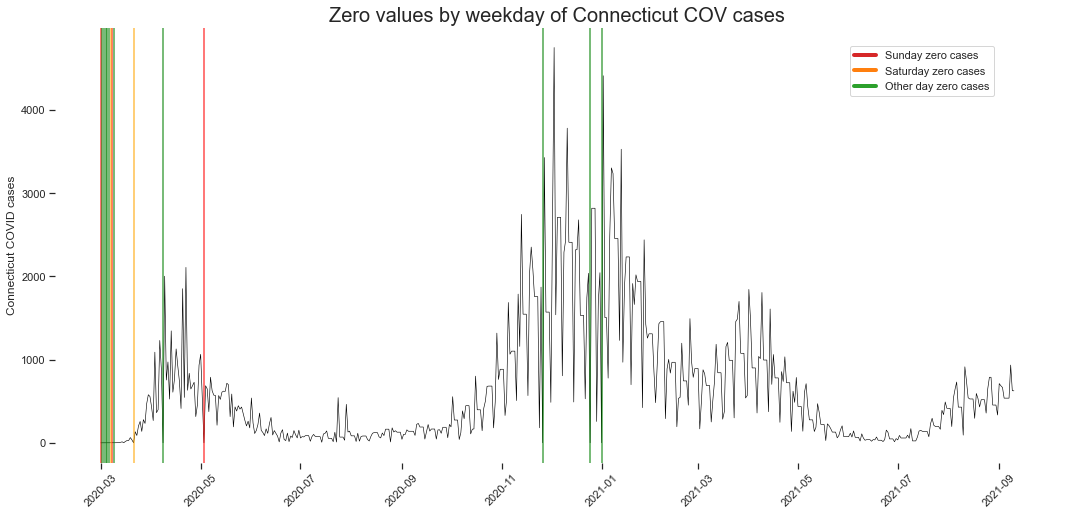

In [69]:
legend_elements = [Line2D([0], [0], color='tab:red', lw=4, label='Sunday zero cases'),
                   Line2D([0], [0], color='tab:orange', lw=4, label='Saturday zero cases'),
                   Line2D([0], [0], color='tab:green', lw=4, label='Other day zero cases')]

with sns.axes_style("ticks"):
    fig, ax = plt.subplots()
    plt.plot(df9.index, df9['CT_Conf_Cases'], color = 'black', linewidth=0.6)
    ax.set_ylabel('Connecticut COVID cases')
    plt.xticks(rotation=45)
    for i in sunday_ind_ct:    
        ax.axvline(x=i, color='red', alpha=0.7)
    for i in saturday_ind_ct:    
        ax.axvline(x=i, color='orange', alpha=0.7)
    for i in other_ind_ct:    
        ax.axvline(x=i, color='green', alpha=0.7)
    plt.title('Zero values by weekday of Connecticut COV cases', fontsize=20)
    sns.despine(left=True, bottom=True)
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.94, 0.97))
    plt.show()

## Vermont

Recall that Vermont's reporting schedule was Monday-Friday from 2021-06-01 until 2021-08-23.

In [70]:
# Get rid of Connecticut-specific columns
df9 = df9.drop(['CT_third', 'ct_lag_1', 'ct_lag_2', 'ct_lag_3'], axis=1)

In [71]:
# Create Vermont-specific columns
# VT_third
df9['VT_third'] = round(df9['VT_Conf_Cases']/3)

In [72]:
# vt_lags
vt_lags = {'vt_lag_1': -1, 'vt_lag_2': -2, 'vt_lag_3': -3}
for key, value in vt_lags.items():
    df9[key] = df9['VT_third'].shift(value, axis=0)

In [73]:
for index, row in df9.iterrows():
    if (index >=pd.Timestamp('2021-06-01')) & (index <=pd.Timestamp('2021-08-24')) & (row['weekday']==0) & (row['VT_Conf_Cases'] != 0):
        df9.at[index, 'VT_Conf_Cases'] = df9.at[index, 'VT_third']

In [74]:
for index, row in df9.iterrows():
    if (index >=pd.Timestamp('2021-06-01')) & (index <=pd.Timestamp('2021-08-24'))& (row['weekday']==6) & (row['VT_Conf_Cases'] == 0):
        df9.at[index, 'VT_Conf_Cases'] = df9.at[index, 'vt_lag_1']

In [75]:
for index, row in df9.iterrows():
    if (index >=pd.Timestamp('2021-06-01')) & (index <=pd.Timestamp('2021-08-24')) & (row['weekday']==5) & (row['VT_Conf_Cases'] == 0):
        df9.at[index, 'VT_Conf_Cases'] = df9.at[index, 'vt_lag_2']

Now let's address any long weekends where Monday was a bank holiday by taking a third of that week's Tuesday case count and replacing Saturday, Sunday, and Monday count with that value instead

In [76]:
for index, row in df9.iterrows():
    if (index >=pd.Timestamp('2021-06-01')) & (index <=pd.Timestamp('2021-08-24')) & (row['weekday']==1) & (row['VT_Conf_Cases'] != 0):
        df9.at[index, 'VT_Conf_Cases'] = df9.at[index, 'VT_third']

In [77]:
for index, row in df9.iterrows():
    if (index >=pd.Timestamp('2021-06-01')) & (index <=pd.Timestamp('2021-08-24')) & (row['weekday']==0) & (row['VT_Conf_Cases'] == 0):
        df9.at[index, 'VT_Conf_Cases'] = df9.at[index, 'vt_lag_1']

In [78]:
for index, row in df9.iterrows():
    if (index >=pd.Timestamp('2021-06-01')) & (index <=pd.Timestamp('2021-08-24')) & (row['weekday']==6) & (row['VT_Conf_Cases'] == 0):
        df9.at[index, 'VT_Conf_Cases'] = df9.at[index, 'vt_lag_2']

In [79]:
for index, row in df9.iterrows():
    if (index >=pd.Timestamp('2021-06-01')) & (index <=pd.Timestamp('2021-08-24')) & (row['weekday']==5) & (row['VT_Conf_Cases'] == 0):
        df9.at[index, 'VT_Conf_Cases'] = df9.at[index, 'vt_lag_3']

In [80]:
sunday_ind_vt=(df9[(df9.weekday == 6)&(df9.VT_Conf_Cases==0)]).index # Sunday zero values
saturday_ind_vt=(df9[(df9.weekday == 5)&(df9.VT_Conf_Cases==0)]).index # Saturday zero values
# Zero values that are neither Sunday nor Monday
other_ind_vt=(df9[(df9.weekday != 5)& (df9.weekday != 6)&(df9.VT_Conf_Cases==0)]).index

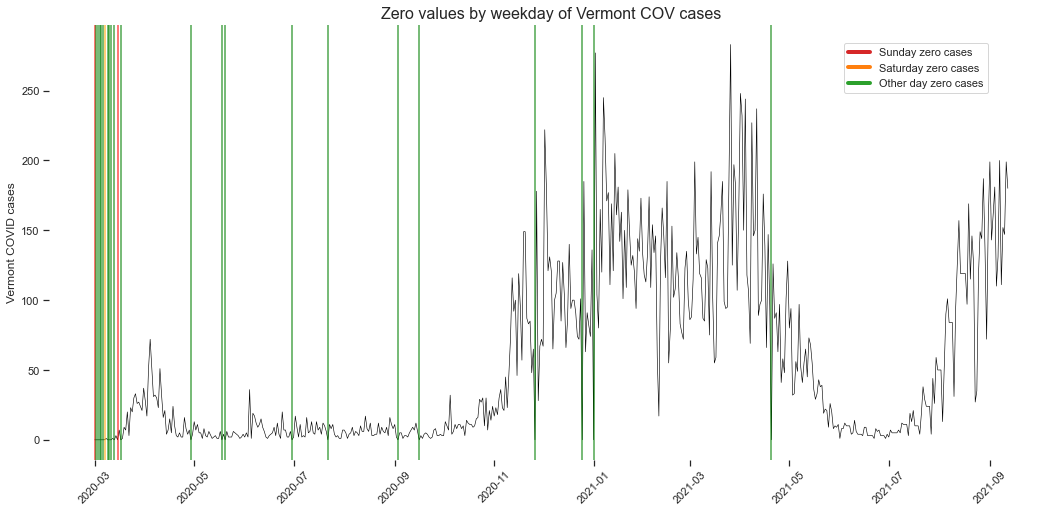

In [81]:
legend_elements = [Line2D([0], [0], color='tab:red', lw=4, label='Sunday zero cases'),
                   Line2D([0], [0], color='tab:orange', lw=4, label='Saturday zero cases'),
                   Line2D([0], [0], color='tab:green', lw=4, label='Other day zero cases')]

with sns.axes_style("ticks"):
    fig, ax = plt.subplots()
    plt.plot(df9.index, df9['VT_Conf_Cases'], color = 'black', linewidth=0.6)
    ax.set_ylabel('Vermont COVID cases')
    plt.xticks(rotation=45)
    for i in sunday_ind_vt:    
        ax.axvline(x=i, color='red', alpha=0.7)
    for i in saturday_ind_vt:    
        ax.axvline(x=i, color='orange', alpha=0.7)
    for i in other_ind_vt:    
        ax.axvline(x=i, color='green', alpha=0.7)
    plt.title('Zero values by weekday of Vermont COV cases', fontsize=16)
    sns.despine(left=True, bottom=True)
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.94, 0.97))
    plt.show()

## Massachusetts

Lastly, Massachusetts' reporting schedule was Monday-Friday from 2021-07-01 onwards.

In [82]:
# Get rid of Vermont-specific columns
df9 = df9.drop(['VT_third', 'vt_lag_1', 'vt_lag_2', 'vt_lag_3'], axis=1)

In [83]:
# Create Massachusetts-specific columns
# MA_third
df9['MA_third'] = round(df9['MA_Conf_Cases']/3)

In [84]:
# ma_lags
ma_lags = {'ma_lag_1': -1, 'ma_lag_2': -2, 'ma_lag_3': -3}
for key, value in ma_lags.items():
    df9[key] = df9['MA_third'].shift(value, axis=0)

In [85]:
for index, row in df9.iterrows():
    if (index>= pd.Timestamp('2021-07-01')) & (row['weekday']==0) & (row['MA_Conf_Cases'] != 0):
        df9.at[index, 'MA_Conf_Cases'] = df9.at[index, 'MA_third']

In [86]:
for index, row in df9.iterrows():
    if (index>= pd.Timestamp('2021-07-01')) & (row['weekday']==6) & (row['MA_Conf_Cases'] == 0):
        df9.at[index, 'MA_Conf_Cases'] = df9.at[index, 'ma_lag_1']

In [87]:
for index, row in df9.iterrows():
    if (index>= pd.Timestamp('2021-07-01')) & (row['weekday']==5) & (row['MA_Conf_Cases'] == 0):
        df9.at[index, 'MA_Conf_Cases'] = df9.at[index, 'ma_lag_2']

Now let's address any long weekends where Monday was a bank holiday by taking a third of that week's Tuesday case count and replacing Saturday, Sunday, and Monday count with that value instead

In [88]:
for index, row in df9.iterrows():
    if (index>= pd.Timestamp('2021-07-01')) & (row['weekday']==1) & (row['MA_Conf_Cases'] != 0):
        df9.at[index, 'MA_Conf_Cases'] = df9.at[index, 'MA_third']

In [89]:
for index, row in df9.iterrows():
    if (index>= pd.Timestamp('2021-07-01')) & (row['weekday']==0) & (row['MA_Conf_Cases'] == 0):
        df9.at[index, 'MA_Conf_Cases'] = df9.at[index, 'ma_lag_1']

In [90]:
for index, row in df9.iterrows():
    if (index>= pd.Timestamp('2021-07-01')) & (row['weekday']==6) & (row['MA_Conf_Cases'] == 0):
        df9.at[index, 'MA_Conf_Cases'] = df9.at[index, 'ma_lag_2']

In [91]:
for index, row in df9.iterrows():
    if (index>= pd.Timestamp('2021-07-01')) & (row['weekday']==5) & (row['MA_Conf_Cases'] == 0):
        df9.at[index, 'MA_Conf_Cases'] = df9.at[index, 'ma_lag_3']

In [92]:
sunday_ind_ma=(df9[(df9.weekday == 6)&(df9.MA_Conf_Cases==0)]).index # Sunday zero values
saturday_ind_ma=(df9[(df9.weekday == 5)&(df9.MA_Conf_Cases==0)]).index # Saturday zero values
# Zero values that are neither Sunday nor Monday
other_ind_ma=(df9[(df9.weekday != 5)& (df9.weekday != 6)&(df9.MA_Conf_Cases==0)]).index 

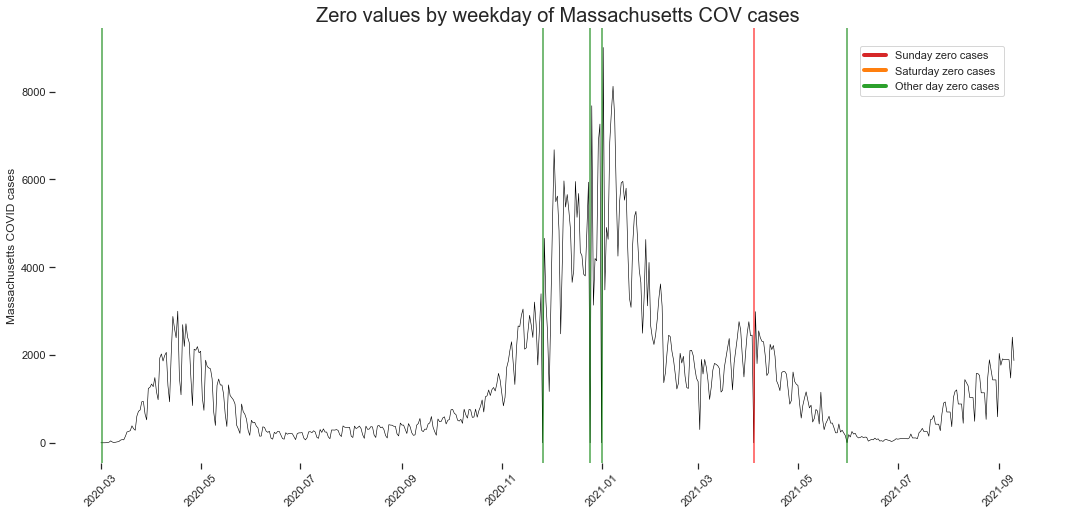

In [93]:
legend_elements = [Line2D([0], [0], color='tab:red', lw=4, label='Sunday zero cases'),
                   Line2D([0], [0], color='tab:orange', lw=4, label='Saturday zero cases'),
                   Line2D([0], [0], color='tab:green', lw=4, label='Other day zero cases')]

with sns.axes_style("ticks"):
    fig, ax = plt.subplots()
    plt.plot(df9.index, df9['MA_Conf_Cases'], color = 'black', linewidth=0.6)
    ax.set_ylabel('Massachusetts COVID cases')
    plt.xticks(rotation=45)
    for i in sunday_ind_ma:    
        ax.axvline(x=i, color='red', alpha=0.7)
    for i in saturday_ind_ma:    
        ax.axvline(x=i, color='orange', alpha=0.7)
    for i in other_ind_ma:    
        ax.axvline(x=i, color='green', alpha=0.7)
    plt.title('Zero values by weekday of Massachusetts COV cases', fontsize=20)
    sns.despine(left=True, bottom=True)
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.95, 0.97))
    plt.show()

In [94]:
# Get rid of Massachusetts-specific columns
df9 = df9.drop(['MA_third', 'ma_lag_1', 'ma_lag_2', 'ma_lag_3'], axis=1)

## Bank Holidays

Now the missing weekend values have been addressed, I'll identify US bank holidays that correspond to missing case counts across most or all of the states. After cross-checking with the US bank holidays listed in the below hyperlinks, I discovered 5 bank holidays where at least 50% of the states did not report any case values. 

Full list of 2020 US Holidays [here](https://www.officeholidays.com/countries/usa/2020).

Full list of 2021 US Holidays [here](https://www.officeholidays.com/countries/usa/2021).

In [95]:
#Create a list of US bank holidays in 2020-2021:
US_bank_holidays = ['2020-12-25', '2020-11-26', '2021-01-01', '2021-05-31', '2021-09-06']

In [96]:
#Drop rows with indices in US_bank_holidays list:
df9= df9.drop(df9[(df9.index.isin(US_bank_holidays))].index)
#df7=df6

In [97]:
remaining_missing_MA = []
remaining_missing_ME = []
remaining_missing_CT = []
remaining_missing_VT = []

for index, row in df9.iterrows():
    if row['MA_Conf_Cases'] == 0:
        remaining_missing_MA.append(index)
    elif row['CT_Conf_Cases'] == 0:
        remaining_missing_CT.append(index)
    elif row['ME_Conf_Cases'] == 0:
        remaining_missing_ME.append(index)
    elif row['VT_Conf_Cases'] == 0:
        remaining_missing_VT.append(index)
    else:
        continue

In [98]:
len(remaining_missing_MA)

2

In [99]:
len(remaining_missing_ME)

9

In [100]:
len(remaining_missing_VT)

11

In [101]:
len(remaining_missing_CT)

11

In [102]:
# Replace cases negative values with np.nan
df9.MA_Conf_Cases[remaining_missing_MA] = np.nan
df9.CT_Conf_Cases[remaining_missing_CT] = np.nan
df9.VT_Conf_Cases[remaining_missing_VT] = np.nan
df9.ME_Conf_Cases[remaining_missing_ME] = np.nan

<ipython-input-102-b3192cc0fc9c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9.MA_Conf_Cases[remaining_missing_MA] = np.nan
/Users/abigailmorgan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-102-b3192cc0fc9c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9.CT_Conf_Cases[remaining_missing_CT

In [103]:
# Loop through NaNs and fill with average of previous and following cell values 
state_col_list=['CT_Conf_Cases', 'VT_Conf_Cases', 'ME_Conf_Cases', 'MA_Conf_Cases']
for col in state_col_list:
    df9[col] = df9[col].fillna((df9[col].shift() + df9[col].shift(-1))/2)

Let's double check for any remaining `NaN`s, as many machine learning models cannot work with them. It would be expected that we may still have some `NaN`s if we consider that towards the start of the pandemic, there may have been multiple days in a row with zero cases. Because we filled `NaN`s with the average of the value before and after the `NaN` value, we may have inadvertantly tried to divide by zero. Any number divided by zero is undefined, and would have left the `NaN` value in place. Let's see how many `NaN`s remaining, and as long as there aren't too many, let's convert them back to zeroes. 

In [104]:
# How many remaining NaN values?
df9.isna().sum()

VT_Avg_Temp(F)     0
VT_PRCP(mm)        0
ME_Avg_Temp(F)     0
ME_PRCP(mm)        0
CT_Avg_Temp(F)     0
CT_PRCP(mm)        0
MA_Avg_Temp(F)     0
MA_PRCP(mm)        0
CT_Conf_Cases     10
VT_Conf_Cases      0
ME_Conf_Cases      3
MA_Conf_Cases      2
weekday            0
dtype: int64

Great! We only have 14 `NaN`s left. Let's fill these with zeroes before saving the file.

In [105]:
# Fill remaining NaNs
df9.fillna(0, inplace=True)

In [106]:
# Double check all NaNs are gone:
df9.isna().sum()

VT_Avg_Temp(F)    0
VT_PRCP(mm)       0
ME_Avg_Temp(F)    0
ME_PRCP(mm)       0
CT_Avg_Temp(F)    0
CT_PRCP(mm)       0
MA_Avg_Temp(F)    0
MA_PRCP(mm)       0
CT_Conf_Cases     0
VT_Conf_Cases     0
ME_Conf_Cases     0
MA_Conf_Cases     0
weekday           0
dtype: int64

In [107]:
#Recheck summary statistics with dropped US_bank_holidays:
df9.describe()

,VT_Avg_Temp(F),VT_PRCP(mm),ME_Avg_Temp(F),ME_PRCP(mm),CT_Avg_Temp(F),CT_PRCP(mm),MA_Avg_Temp(F),MA_PRCP(mm),CT_Conf_Cases,VT_Conf_Cases,ME_Conf_Cases,MA_Conf_Cases,weekday
count,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.00000
mean,52.922086,2.216906,46.957482,2.758813,55.734101,3.444065,55.747212,3.807554,631.555755,53.984712,142.645234,1393.040468,3.01259
std,19.309202,5.847020,18.946583,8.736485,17.157581,10.079365,16.649610,10.521366,737.717819,61.979437,168.460948,1554.231094,2.00401
min,4.100000,0.000000,1.580000,0.000000,11.660000,0.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,38.390000,0.000000,32.000000,0.000000,41.450000,0.000000,41.900000,0.000000,117.750000,5.000000,24.000000,285.750000,1.00000
50%,54.680000,0.000000,48.920000,0.000000,57.290000,0.000000,56.750000,0.000000,397.000000,20.500000,54.000000,882.000000,3.00000
75%,68.900000,1.075000,63.500000,1.300000,70.880000,1.075000,69.440000,2.000000,845.500000,99.250000,215.500000,1947.750000,5.00000
max,84.920000,63.500000,80.060000,131.100000,85.640000,103.400000,87.980000,95.000000,4751.000000,283.000000,824.000000,9003.000000,6.00000


Now that we've finished addressing missing values, let's take a final look at the visualization of each state's reported cases over time. 

## Maine

No handles with labels found to put in legend.


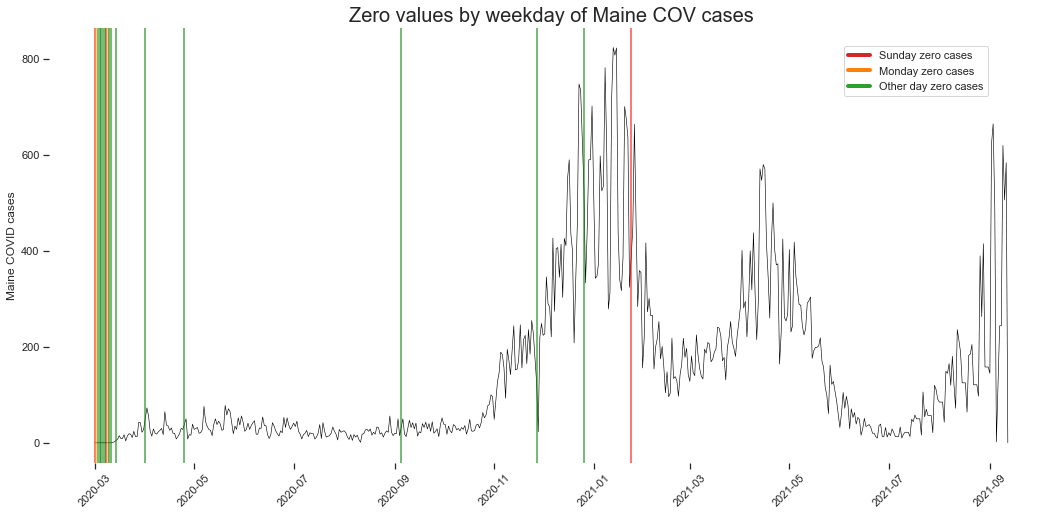

In [108]:
legend_elements = [Line2D([0], [0], color='tab:red', lw=4, label='Sunday zero cases'),
                   Line2D([0], [0], color='tab:orange', lw=4, label='Monday zero cases'),
                   Line2D([0], [0], color='tab:green', lw=4, label='Other day zero cases')]

sns.set(rc={'figure.figsize':(18,8)})
with sns.axes_style("ticks"):
    fig, ax = plt.subplots()
    plt.plot(df9.index, df9['ME_Conf_Cases'], color = 'black', linewidth=0.6)
    ax.set_ylabel('Maine COVID cases')
    plt.xticks(rotation=45)
    for i in sunday_ind_me:    
        ax.axvline(x=i, color='red', alpha=0.7)
    for i in monday_ind_me:    
        ax.axvline(x=i, color='orange', alpha=0.7)
    for i in other_ind_me:    
        ax.axvline(x=i, color='green', alpha=0.7)
    plt.title('Zero values by weekday of Maine COV cases', fontsize=20)
    sns.despine(left=True, bottom=True)
    ax.legend()
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.94, 0.97))
    plt.show()

## Connecticut

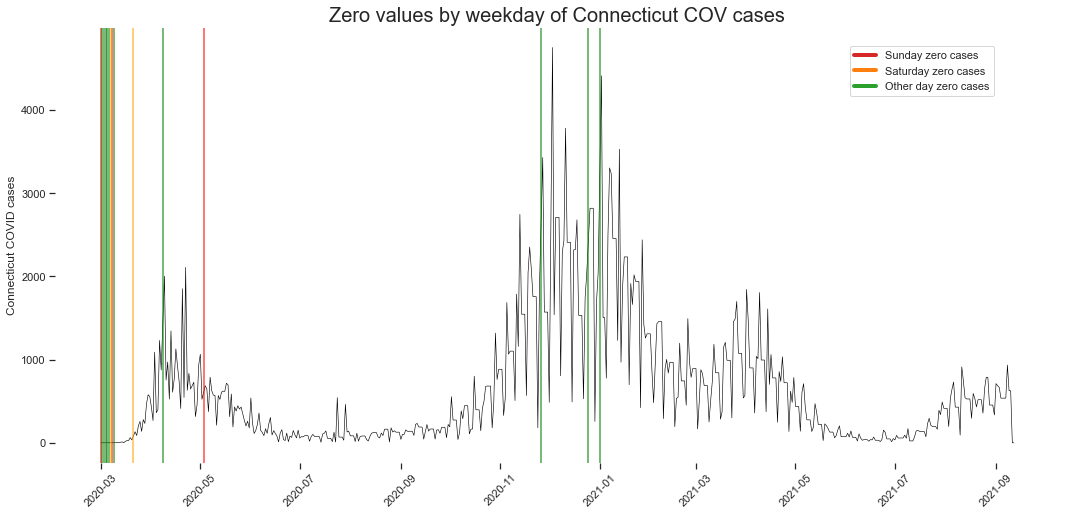

In [109]:
legend_elements = [Line2D([0], [0], color='tab:red', lw=4, label='Sunday zero cases'),
                   Line2D([0], [0], color='tab:orange', lw=4, label='Saturday zero cases'),
                   Line2D([0], [0], color='tab:green', lw=4, label='Other day zero cases')]

with sns.axes_style("ticks"):
    fig, ax = plt.subplots()
    plt.plot(df9.index, df9['CT_Conf_Cases'], color = 'black', linewidth=0.6)
    ax.set_ylabel('Connecticut COVID cases')
    plt.xticks(rotation=45)
    for i in sunday_ind_ct:    
        ax.axvline(x=i, color='red', alpha=0.7)
    for i in saturday_ind_ct:    
        ax.axvline(x=i, color='orange', alpha=0.7)
    for i in other_ind_ct:    
        ax.axvline(x=i, color='green', alpha=0.7)
    plt.title('Zero values by weekday of Connecticut COV cases', fontsize=20)
    sns.despine(left=True, bottom=True)
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.94, 0.97))
    plt.show()

## Vermont

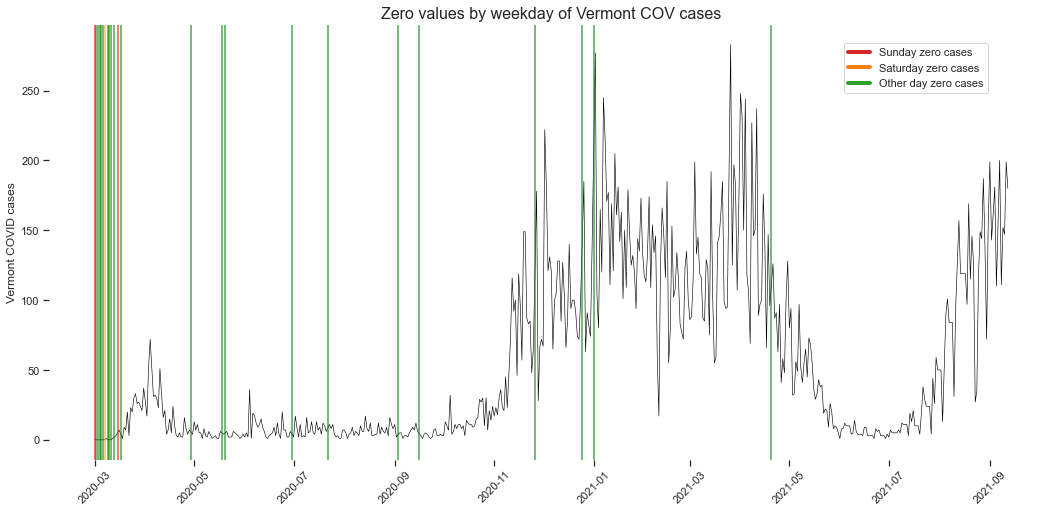

In [110]:
legend_elements = [Line2D([0], [0], color='tab:red', lw=4, label='Sunday zero cases'),
                   Line2D([0], [0], color='tab:orange', lw=4, label='Saturday zero cases'),
                   Line2D([0], [0], color='tab:green', lw=4, label='Other day zero cases')]

with sns.axes_style("ticks"):
    fig, ax = plt.subplots()
    plt.plot(df9.index, df9['VT_Conf_Cases'], color = 'black', linewidth=0.6)
    ax.set_ylabel('Vermont COVID cases')
    plt.xticks(rotation=45)
    for i in sunday_ind_vt:    
        ax.axvline(x=i, color='red', alpha=0.7)
    for i in saturday_ind_vt:    
        ax.axvline(x=i, color='orange', alpha=0.7)
    for i in other_ind_vt:    
        ax.axvline(x=i, color='green', alpha=0.7)
    plt.title('Zero values by weekday of Vermont COV cases', fontsize=16)
    sns.despine(left=True, bottom=True)
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.94, 0.97))
    plt.show()

## Massachusetts

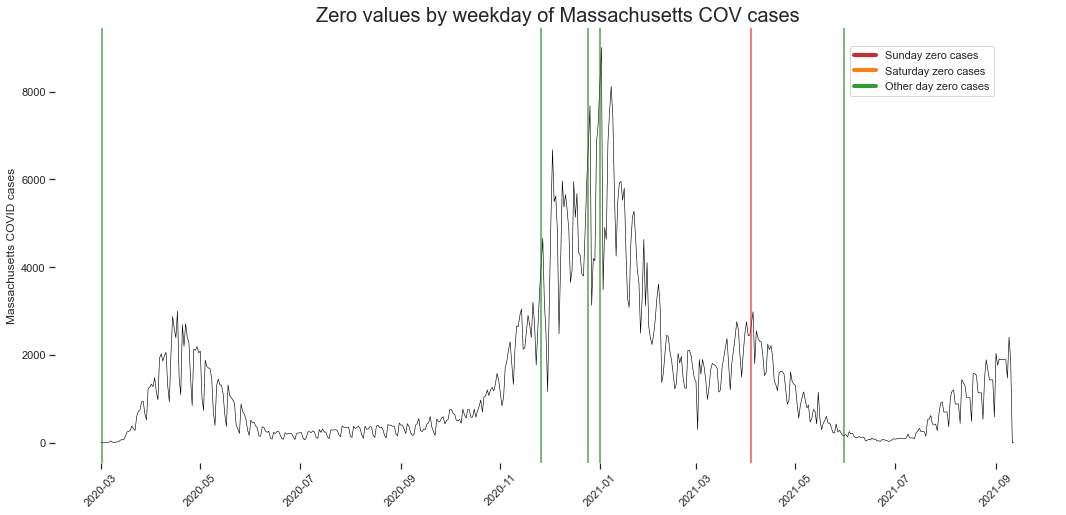

In [111]:
legend_elements = [Line2D([0], [0], color='tab:red', lw=4, label='Sunday zero cases'),
                   Line2D([0], [0], color='tab:orange', lw=4, label='Saturday zero cases'),
                   Line2D([0], [0], color='tab:green', lw=4, label='Other day zero cases')]

with sns.axes_style("ticks"):
    fig, ax = plt.subplots()
    plt.plot(df9.index, df9['MA_Conf_Cases'], color = 'black', linewidth=0.6)
    ax.set_ylabel('Massachusetts COVID cases')
    plt.xticks(rotation=45)
    for i in sunday_ind_ma:    
        ax.axvline(x=i, color='red', alpha=0.7)
    for i in saturday_ind_ma:    
        ax.axvline(x=i, color='orange', alpha=0.7)
    for i in other_ind_ma:    
        ax.axvline(x=i, color='green', alpha=0.7)
    plt.title('Zero values by weekday of Massachusetts COV cases', fontsize=20)
    sns.despine(left=True, bottom=True)
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.94, 0.97))
    plt.show()

We still have a few random missing values, but the data look much better! 

In [112]:
df10 = df9.copy()

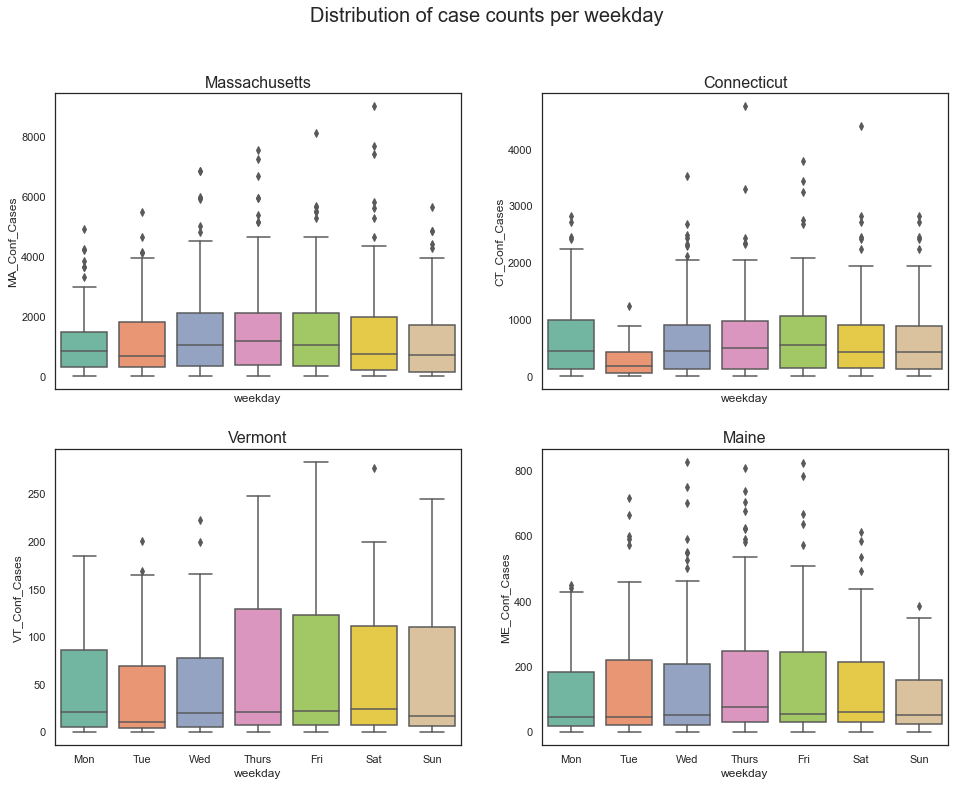

In [113]:
# Plot boxplot of distribution of cases per weekday
#plt.rcParams["figure.figsize"] = [7.50, 3.50]
with sns.axes_style("white"):
    fig, axes = plt.subplots(2,2, sharex=True, figsize=(16,12))
    fig.suptitle('Distribution of case counts per weekday', fontsize=20)
    # Set suptitle and subtitles
    axes[0,0].set_title('Massachusetts', fontsize=16)
    axes[0,1].set_title('Connecticut', fontsize =16)
    axes[1,0].set_title('Vermont', fontsize= 16)
    axes[1,1].set_title('Maine', fontsize= 16)
    #Maine
    sns.boxplot(ax=axes[0, 0], data=df10, x='weekday', y='MA_Conf_Cases', palette = 'Set2')
    plt.xticks(weekday_nums, weekdays)
    #Connecticut
    sns.boxplot(ax=axes[0, 1], data=df10, x='weekday', y='CT_Conf_Cases', palette = 'Set2')
    plt.xticks(weekday_nums, weekdays)
    # Vermont
    sns.boxplot(ax=axes[1, 0], data=df10, x='weekday', y='VT_Conf_Cases', palette = 'Set2')
    plt.xticks(weekday_nums, weekdays)
    #Massachusetts
    sns.boxplot(ax=axes[1, 1], data=df10, x='weekday', y='ME_Conf_Cases', palette = 'Set2')
    plt.xticks(weekday_nums, weekdays)
    plt.show()

These boxplots look much more evenly distributed! We can still see some remnants of the effects of each state's reporting schedules, but the data is now much more balanced throughout the week.

In [114]:
df10.reset_index(inplace=True)

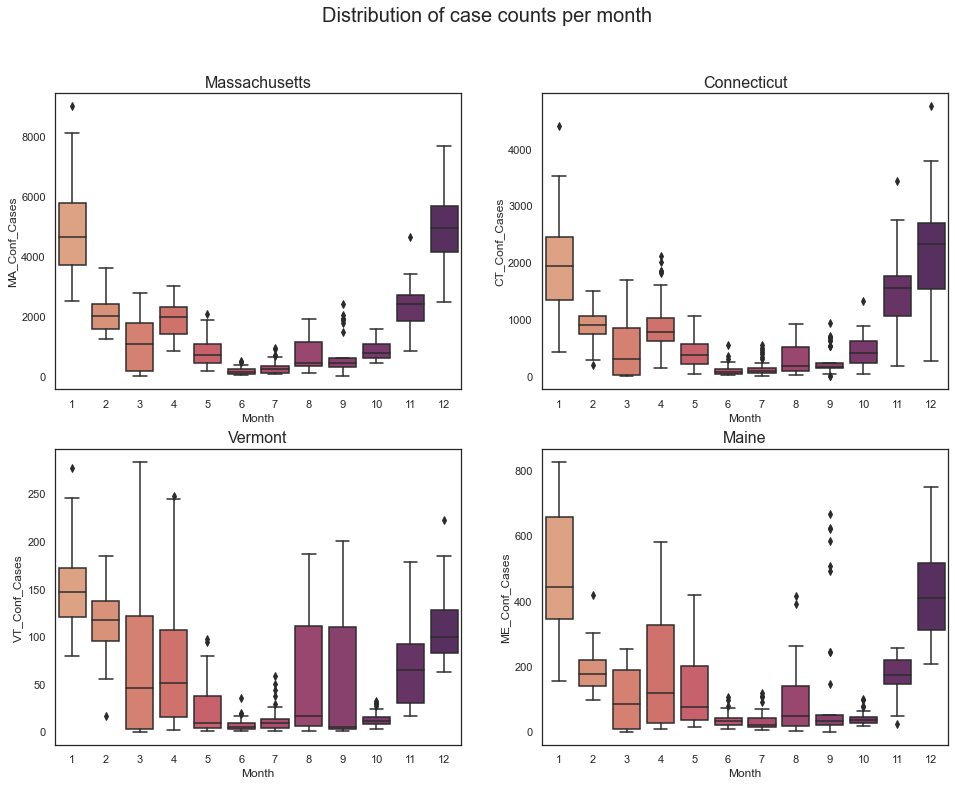

In [115]:
# Plot boxplot of distribution of cases per month

with sns.axes_style("white"):
    fig, axes = plt.subplots(2,2, sharex=False, figsize=(16,12))
    fig.suptitle('Distribution of case counts per month', fontsize=20)
    # Set suptitle and subtitles
    axes[0,0].set_title('Massachusetts', fontsize=16)
    axes[0,0].set_xlabel('Month')
    axes[0,1].set_title('Connecticut', fontsize =16)
    axes[0,1].set_xlabel('Month')
    axes[1,0].set_title('Vermont', fontsize=16)
    axes[1,0].set_xlabel('Month')
    axes[1,1].set_title('Maine', fontsize=16)
    axes[1,1].set_xlabel('Month')
    #Maine
    sns.boxplot(ax=axes[0, 0], data=df10, x=[i.month for i in df10['date']], y='MA_Conf_Cases', palette = 'flare')
    #plt.xticks(month_nums, months)
    #Connecticut
    sns.boxplot(ax=axes[0, 1], data=df10, x=[i.month for i in df10['date']], y='CT_Conf_Cases', palette = 'flare')
    #plt.xticks(month_nums, months)
    # Vermont
    sns.boxplot(ax=axes[1, 0], data=df10, x=[i.month for i in df10['date']], y='VT_Conf_Cases', palette = 'flare')
    #plt.xticks(month_nums, months)
    #Massachusetts
    sns.boxplot(ax=axes[1, 1], data=df10, x=[i.month for i in df10['date']], y='ME_Conf_Cases', palette = 'flare')
    #plt.xticks(month_nums, months)
    plt.show()

In [116]:
df9

,VT_Avg_Temp(F),VT_PRCP(mm),ME_Avg_Temp(F),ME_PRCP(mm),CT_Avg_Temp(F),CT_PRCP(mm),MA_Avg_Temp(F),MA_PRCP(mm),CT_Conf_Cases,VT_Conf_Cases,ME_Conf_Cases,MA_Conf_Cases,weekday
date,,,,,,,,,,,,,
2020-03-01,19.58,0.3,14.18,0.3,26.24,0.0,26.42,0.0,0.0,0.0,0.0,1.0,6
2020-03-02,32.00,0.0,17.06,4.6,37.58,0.0,36.50,0.0,0.0,0.0,0.0,1.0,0
2020-03-03,44.06,2.8,39.56,0.0,51.26,3.8,55.94,0.0,0.0,0.0,0.0,1.0,1
2020-03-04,41.54,0.0,32.00,6.6,48.02,0.0,46.94,2.5,0.0,0.0,0.0,2.0,2
2020-03-05,37.04,0.0,30.02,0.0,43.16,0.0,42.98,0.0,0.0,0.0,0.0,8.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-08,72.86,24.1,63.50,0.0,70.16,0.0,71.96,0.0,935.0,111.0,244.0,1475.0,2
2021-09-09,67.46,0.0,62.42,35.3,71.42,3.8,70.88,8.1,626.0,152.0,620.0,2407.0,3
2021-09-10,59.90,0.5,58.46,13.0,66.92,0.0,68.54,7.6,625.0,147.0,506.0,1873.0,4


In [ ]:
#  DateTimeIndex
#df9.set_index('date', inplace=True)

In [ ]:
# save the data to a new csv file
#df9.to_csv('state_cov_weather2.csv')

In [122]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

In [123]:
y = df9['MA_Conf_Cases']

In [126]:
y

date
2020-03-01       1.0
2020-03-02       1.0
2020-03-03       1.0
2020-03-04       2.0
2020-03-05       8.0
               ...  
2021-09-08    1475.0
2021-09-09    2407.0
2021-09-10    1873.0
2021-09-11       0.0
2021-09-12       0.0
Name: MA_Conf_Cases, Length: 556, dtype: float64

In [128]:
decomposition = seasonal_decompose(y, model='additive', period = int(len(df)/2))
decomposition.plot()

ValueError: x must have 2 complete cycles requires 600 observations. x only has 556 observation(s)

## Plots:

With so many twin axes to plot, I'll define a function to help plot all of twin axes time series data:

In [ ]:
def plot_timeseries(axes, x, y, color, xlabel, ylabel):
    axes.plot(x,y,color=color)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.tick_params('y', colors = color)

## Connecticut

In [ ]:
#sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(rc={'figure.figsize':(18,8)})

In [ ]:
#Plot CT time vs confirmed cases
fig, ax = plt.subplots()
plot_timeseries(ax, df9.index, df9['CT_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
#Plot CT temp vs time
plot_timeseries(ax2, df9.index, df9['CT_Avg_Temp(F)'], 'red', 'Time', 'Average Temperature (F)')
plt.title('Connecticut temp vs conf cases over time')
plt.xticks(rotation=90)
plt.show()

In [ ]:
#Plot CT time vs confirmed cases
fig, ax = plt.subplots()
plot_timeseries(ax, df9.index, df9['CT_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
#Plot CT prcp vs time
plot_timeseries(ax2, df9.index, df9['CT_PRCP(mm)'], 'red', 'Time', 'CT_PRCP(mm)')
plt.title('Connecticut prcp vs confirmed cases over time')
plt.xticks(rotation=90)
plt.show()

***

## Maine

In [ ]:
#Plot ME time vs Avg. Temp 
fig, ax = plt.subplots()
plot_timeseries(ax, df9.index, df9['ME_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
plot_timeseries(ax2, df9.index, df9['ME_Avg_Temp(F)'], 'red', 'Time', 'Average Temperature (F)')
plt.title('Maine Temp vs Conf Cases')
plt.xticks(rotation=90)
plt.show()

In [ ]:
#Plot ME time vs confirmed cases
fig, ax = plt.subplots()
plot_timeseries(ax, df9.index, df9['ME_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
#Plot ME prcp vs time
plot_timeseries(ax2, df9.index, df9['ME_PRCP(mm)'], 'red', 'Time', 'ME_PRCP(mm)')
plt.title('Maine prcp vs confirmed cases over time')
plt.xticks(rotation=90)
plt.show()

## Massachusetts

In [ ]:
#Plot MA time vs confirmed cases
fig, ax = plt.subplots()
plot_timeseries(ax, df9.index, df9['MA_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
#Plot MA temp vs time
plot_timeseries(ax2, df9.index, df9['MA_Avg_Temp(F)'], 'red', 'Time', 'MA_Avg_Temp(F)')
plt.title('Massachusetts TAVG vs confirmed cases over time')
plt.xticks(rotation=90)
plt.show()

In [ ]:
#Plot MA time vs confirmed cases
fig, ax = plt.subplots()
plot_timeseries(ax, df9.index, df9['MA_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
#Plot MA prcp vs time
plot_timeseries(ax2, df9.index, df9['MA_PRCP(mm)'], 'red', 'Time', 'MA_PRCP(mm)')
plt.title('Massachusetts prcp vs confirmed cases over time')
plt.xticks(rotation=90)
plt.show()

## Vermont

In [ ]:
#Plot VT time vs confirmed cases
fig, ax = plt.subplots()
plot_timeseries(ax, df9.index, df9['VT_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
#Plot VT temp vs time
plot_timeseries(ax2, df9.index, df9['VT_Avg_Temp(F)'], 'red', 'Time', 'VT_Avg_Temp(F)')
plt.title('Vermont TAVG vs confirmed cases over time')
plt.xticks(rotation=90)
plt.show()

In [ ]:
#Plot VT time vs confirmed cases
fig, ax = plt.subplots()
plot_timeseries(ax, df9.index, df9['VT_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
#Plot MA prcp vs time
plot_timeseries(ax2, df9.index, df9['VT_PRCP(mm)'], 'red', 'Time', 'VT_PRCP(mm)')
plt.title('Vermont prcp vs confirmed cases over time')
plt.xticks(rotation=90)
plt.show()

## Perform Shapiro-Wilk test for normality:

In [ ]:
#Convert dataframe to array to perform Shapiro-Wilcox test:
np_cov_weather9 = df9.to_numpy()

In [ ]:
#Apply Shapiro test:
shapiro_test = stats.shapiro(np_cov_weather9)

In [ ]:
#Print values:
print("Shapiro test statistic is: ", shapiro_test.statistic)
print("Shapiro p-value is: ", shapiro_test.pvalue)

## Predictive Power Score:

In [ ]:
#Calculate ppscore 
pps = ppscore.matrix(df9)

In [ ]:
print(pps)

In [ ]:
print(df9.dtypes)

In [ ]:
matrix_df = ppscore.matrix(df9).pivot(columns='x', index='y',  values='ppscore')

In [ ]:
sns.set(rc={'figure.figsize':(14.5,11.5)})
ax=plt.axes()
sns.heatmap(matrix_df, annot= True)
ax.set_title("Predictive power score between COV cases and weather data", fontsize=18)
plt.show()

In [ ]:
ax=plt.axes()
sns.set(rc={'figure.figsize':(15,12)})
sns.heatmap(df9.corr(), square=True, annot=True)
ax.set_title("Correlation between COV cases and weather data", fontsize=18)
plt.show()

In [ ]:
# Use hierarchical clustering with heatmap: clustermap
sns.set(rc={'figure.figsize':(16,13)})
fig = sns.clustermap(df9.corr(), annot=False, 
                     linewidth=0.1).fig.suptitle("Clustered correlation between COV cases and weather data", 
                     fontsize=18, y=1.02)
#plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0)
#plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.show()

The clustermap is much easier to interpret than the unclustered heatmap, and visually points us immediately the correlation between average temperatures and confirmed case counts. The clustermap has also grouped Massachusetts values most closely with Connecticut values for each observation, as well as Vermont values most closely with Maine values. This is not surprising, as this is also the geographical grouping of the states.

In [ ]:
CT = df9[['CT_Avg_Temp(F)', 'CT_PRCP(mm)', 'CT_Conf_Cases']]

In [ ]:
ax = plt.axes()
sns.set(rc={'figure.figsize':(4,3)})
fig = sns.heatmap(CT.corr(), square=True, cmap='rocket', annot = True)
ax.set_title("Correlation between CT COV and weather data", fontsize=18)

In [ ]:
MA = df9[['MA_Avg_Temp(F)', 'MA_PRCP(mm)', 'MA_Conf_Cases']]

In [ ]:
ax = plt.axes()
sns.heatmap(MA.corr(), square=True, cmap='rocket', annot=True)
ax.set_title("Correlation between MA COV and weather data", fontsize=18)

In [ ]:
VT= df9[['VT_Avg_Temp(F)', 'VT_PRCP(mm)', 'VT_Conf_Cases']]

In [ ]:
ax = plt.axes()
sns.heatmap(VT.corr(), square=True, cmap='rocket', annot=True)
ax.set_title("Correlation between VT COV and weather data", fontsize=18)

In [ ]:
ME = df9[['ME_Avg_Temp(F)', 'ME_PRCP(mm)', 'ME_Conf_Cases']]

In [ ]:
ax = plt.axes()
sns.heatmap(ME.corr(), square=True, cmap='rocket', annot=True)
ax.set_title("Correlation between ME COV and weather data", fontsize=18)